In [1]:
# CIS 3D color router verification
# Find OE

# ## 1. Simulation Environment

import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt
import os
import math

mp.verbosity(1)

design_dir = "./CIS_result_9_GB/"

# 디렉터리가 없으면 생성
if not os.path.exists(design_dir):
    os.makedirs(design_dir)

# scaling & refractive index
um_scale = 2

Air = mp.Medium(index=1.0)
SiN = mp.Medium(epsilon=4)
SiO2 = mp.Medium(epsilon=2.1)
TiO2 = mp.Medium(epsilon=7)
SiPD = mp.Medium(epsilon=11.8)

# 설계 공간
design_region_width_x = 2.8 # 디자인 영역 x
design_region_width_y = 2.8 # 디자인 영역 y
design_region_height = 2 # 디자인 영역 높이 z

# 해상도 및 사이즈 설정
resolution = 25
gapop = 0 ####################################################################################################
air_gap = 0
dti = 0.4
subpixelsize = design_region_width_x/2 - dti
if gapop == 1:
    air_gap = dti/2
PDsize = 2
Lpml = 1 # PML 영역 크기
pml_layers = [mp.PML(thickness = Lpml, )]
Sourcespace = 1


# 전체 공간
Sx = design_region_width_x * 3
Sy = design_region_width_y * 3
Sz = PDsize + design_region_height + Sourcespace + Lpml
cell_size = mp.Vector3(Sx + 2*Lpml, Sy + 2*Lpml, Sz)

# structure load
structure_weight = np.loadtxt('lastdesign.txt')


# 파장, 주파수 설정
wavelengths = np.linspace(0.40*um_scale, 0.70*um_scale, 31) 
frequencies = 1/wavelengths
nf = len(frequencies) # number of frequencies

# constraint 설정
minimum_length = 0.025  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)

# source 설정

fcen_red = 1/(0.65*um_scale)
fwidth_red = 1 /(0.60 * um_scale) - 1/(0.70 * um_scale)

fcen_green = 1/(0.55*um_scale)
fwidth_green = 1 /(0.50 * um_scale) - 1/(0.60 * um_scale)

fcen_blue = 1/(0.45*um_scale)
fwidth_blue = 1 /(0.40 * um_scale) - 1/(0.50 * um_scale)

src_0 = mp.GaussianSource(frequency=fcen_red, fwidth= 2 * 2.355 * fwidth_red, is_integrated=True)

src_1 = mp.GaussianSource(frequency=fcen_green, fwidth=2 * 2.355 *fwidth_green, is_integrated=True)

src_2 = mp.GaussianSource(frequency=fcen_blue, fwidth=2 * 2.355 *fwidth_blue, is_integrated=True)

source_center = [0, 0, Sz / 2 - Lpml - Sourcespace / 2] # Source 위치
source_size = mp.Vector3(Sx, Sy, 0)

source = [mp.Source(src_0, component=mp.Ex, size=source_size, center=source_center,),mp.Source(src_0, component=mp.Ey, size=source_size, center=source_center,),
            mp.Source(src_1, component=mp.Ex, size=source_size, center=source_center,),mp.Source(src_1, component=mp.Ey, size=source_size, center=source_center,),
            mp.Source(src_2, component=mp.Ex, size=source_size, center=source_center,),mp.Source(src_2, component=mp.Ey, size=source_size, center=source_center,)]


# 설계 영역의 픽셀 - 해상도와 디자인 영역에 따라 결정
Nx = int(round(design_region_resolution * design_region_width_x)) + 1
Ny = int(round(design_region_resolution * design_region_width_y)) + 1
Nz = int(round(design_region_resolution * design_region_height)) + 1

# 설계 영역과 물질을 바탕으로 설계 영역 설정
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny, Nz), SiO2, TiO2, grid_type="U_MEAN")

design_variables.update_weights(structure_weight)

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace - design_region_height/2),
        size=mp.Vector3(design_region_width_x-air_gap*2, design_region_width_y-air_gap*2, design_region_height),
    ),
)

# design region과 동일한 size의 Block 생성
geometry = [
    # design region
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),
    mp.Block(
        center=mp.Vector3(Sx/3, 0, Sz / 2 - Lpml - Sourcespace - design_region_height/2), size=design_region.size, material=design_variables
    ),
    mp.Block(
        center=mp.Vector3(-Sx/3, 0, Sz / 2 - Lpml - Sourcespace - design_region_height/2), size=design_region.size, material=design_variables
    ),
    mp.Block(
        center=mp.Vector3(0, Sy/3, Sz / 2 - Lpml - Sourcespace - design_region_height/2), size=design_region.size, material=design_variables
    ),
    mp.Block(
        center=mp.Vector3(0, -Sy/3, Sz / 2 - Lpml - Sourcespace - design_region_height/2), size=design_region.size, material=design_variables
    ),
    mp.Block(
        center=mp.Vector3(Sx/3, Sy/3, Sz / 2 - Lpml - Sourcespace - design_region_height/2), size=design_region.size, material=design_variables
    ),
    mp.Block(
        center=mp.Vector3(-Sx/3, Sy/3, Sz / 2 - Lpml - Sourcespace - design_region_height/2), size=design_region.size, material=design_variables
    ),
    mp.Block(
        center=mp.Vector3(Sx/3, -Sy/3, Sz / 2 - Lpml - Sourcespace - design_region_height/2), size=design_region.size, material=design_variables
    ),
    mp.Block(
        center=mp.Vector3(-Sx/3, -Sy/3, Sz / 2 - Lpml - Sourcespace - design_region_height/2), size=design_region.size, material=design_variables
    ),
    
    # SiO2
    mp.Block(
        center=mp.Vector3(0, 0, -Sz/2 + PDsize/2), size=mp.Vector3(Sx, Sy, PDsize), material=SiO2
    ),
    
    # DTI가 있을 경우 사용
    mp.Block(
        center=mp.Vector3(Sx/12, Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(-Sx/12, -Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(Sx/12, -Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(-Sx/12, Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    
    mp.Block(
        center=mp.Vector3(Sx/3+Sx/12, Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(Sx/3-Sx/12, -Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(Sx/3+Sx/12, -Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(Sx/3-Sx/12, Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    
    mp.Block(
        center=mp.Vector3(-Sx/3+Sx/12, Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(-Sx/3-Sx/12, -Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(-Sx/3+Sx/12, -Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(-Sx/3-Sx/12, Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    
    mp.Block(
        center=mp.Vector3(Sx/12, Sy/3+Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(-Sx/12, Sy/3-Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(Sx/12, Sy/3-Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(-Sx/12, Sy/3+Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    
    mp.Block(
        center=mp.Vector3(Sx/12, -Sy/3+Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(-Sx/12, -Sy/3-Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(Sx/12, -Sy/3-Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(-Sx/12, -Sy/3+Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    
    mp.Block(
        center=mp.Vector3(Sx/3+Sx/12, Sy/3+Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(Sx/3-Sx/12, Sy/3-Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(Sx/3+Sx/12, Sy/3-Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(Sx/3-Sx/12, Sy/3+Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    
    mp.Block(
        center=mp.Vector3(-Sx/3+Sx/12, Sy/3+Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(-Sx/3-Sx/12, Sy/3-Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(-Sx/3+Sx/12, Sy/3-Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(-Sx/3-Sx/12, Sy/3+Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    
    mp.Block(
        center=mp.Vector3(Sx/3+Sx/12, -Sy/3+Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(Sx/3-Sx/12, -Sy/3-Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(Sx/3+Sx/12, -Sy/3-Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(Sx/3-Sx/12, -Sy/3+Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    
    mp.Block(
        center=mp.Vector3(-Sx/3+Sx/12, -Sy/3+Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(-Sx/3-Sx/12, -Sy/3-Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(-Sx/3+Sx/12, -Sy/3-Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
    mp.Block(
        center=mp.Vector3(-Sx/3-Sx/12, -Sy/3+Sy/12, -Sz/2 + PDsize/2), size=mp.Vector3(subpixelsize, subpixelsize,  PDsize), material=SiPD
    ),
]

sim = mp.Simulation(
    cell_size=cell_size, 
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air, # 빈공간
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

In [2]:
###############################################################################################################################
# ## 2. Optimization Environment


# 모니터 위치와 크기 설정 (focal point)
monitor_position_0, monitor_size_0 = mp.Vector3(-design_region_width_x/4, design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_1, monitor_size_1 = mp.Vector3(-design_region_width_x/4, -design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_2, monitor_size_2 = mp.Vector3(design_region_width_x/4, -design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_3, monitor_size_3 = mp.Vector3(design_region_width_x/4, design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), mp.Vector3(0.01,0.01,0) 

# FourierFields를 통해 monitor_position에서 monitor_size만큼의 영역에 대한 Fourier transform을 구함

FourierFields_0_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ex,yee_grid=True)

FourierFields_1_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ex,yee_grid=True)

FourierFields_2_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ex,yee_grid=True)

FourierFields_3_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ex,yee_grid=True)

FourierFields_0_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ey,yee_grid=True)

FourierFields_1_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ey,yee_grid=True)

FourierFields_2_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ey,yee_grid=True)

FourierFields_3_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ey,yee_grid=True)

ob_list = [FourierFields_0_x, FourierFields_0_y, FourierFields_1_x,FourierFields_1_y, FourierFields_2_x, FourierFields_2_y, FourierFields_3_x, FourierFields_3_y]



# J : Objective function
# FourierFields가 측정한 필드, 모니터의 중심에서 E 구성요소의 절댓값을 제곱한 값을 취한 후 평균을 계산하여 평균 강도를 계산
# [frequency index, moniter index]
def J(fields_0_x, fields_0_y, fields_1_x, fields_1_y, fields_2_x, fields_2_y, fields_3_x, fields_3_y):
    red = npa.sum(npa.abs(fields_1_x[21:30,1]) ** 2)  + npa.sum(npa.abs(fields_1_y[21:30,1]) ** 2)
    green = npa.sum(npa.abs(fields_0_x[11:20,1]) ** 2) + npa.sum(npa.abs(fields_0_y[11:20,1]) ** 2) + npa.sum(npa.abs(fields_2_x[11:20,1]) ** 2) + npa.sum(npa.abs(fields_2_y[11:20,1]) ** 2)
    blue = npa.sum(npa.abs(fields_3_x[1:10,1]) ** 2) + npa.sum(npa.abs(fields_3_y[1:10,1]) ** 2)
    bluefactor = 4
    return bluefactor * blue + green + red

# optimization 설정

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-3,
)

/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:271: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


     block, center = (0,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-2)
          size (8.4,8.4,2)
          axes (1,0,0), (0,1,0), (0,0,1)

     ...(+ 36 objects not shown)...


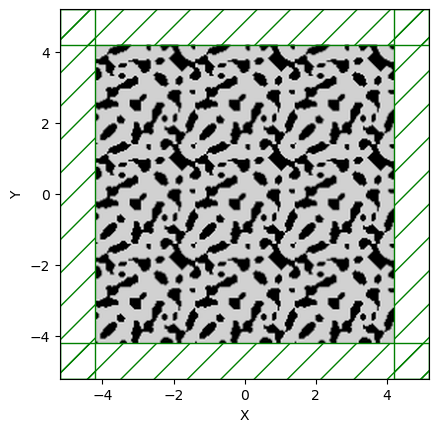

In [3]:
###############################################################################################################################
# ## 3. Design plot

opt.plot2D(False, output_plane = mp.Volume(size = (np.inf, np.inf, 0), center = (0,0,1)))
plt.savefig(design_dir+"Lastdesignxy.png")


     block, center = (0,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-2)
          size (8.4,8.4,2)
          axes (1,0,0), (0,1,0), (0,0,1)

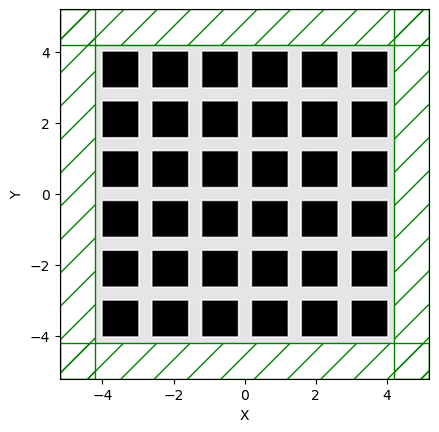

In [4]:
opt.plot2D(False, output_plane = mp.Volume(size = (np.inf, np.inf, 0), center = (0,0,-1)))
plt.savefig(design_dir+"Lastdesignxy.png")

     block, center = (0,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block

, center = (0,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-2)
          size (8.4,8.4,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1,2.1,2.1)
     ...(+ 36 objects not shown)...


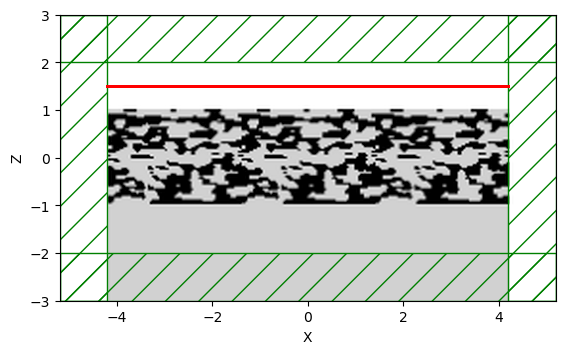

In [5]:
opt.plot2D(False, output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))
plt.savefig(design_dir+"Lastdesignxz.png")

###############################################################################################################################

In [6]:
beam_x0 = mp.Vector3(0, 0, Sourcespace/2)  # beam focus (relative to source center)
rot_angle = 0  # CCW rotation angle about z axis (0: +y axis)
beam_kdir = mp.Vector3(0, 0, -1).rotate(
    mp.Vector3(0, 0, 1), math.radians(rot_angle)
)  # beam propagation direction
beam_w0 = 1.4  # beam waist radius
beam_E0 = mp.Vector3(1, 1, 0)

In [7]:
###############################################################################################################################
# ## 4. DFT fields

# blue pixel

opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

src = mp.GaussianSource(frequency=frequencies[5], fwidth=fwidth_blue, is_integrated=True)
source = [
    mp.GaussianBeam3DSource(
        src = src,
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace/2),
        size=mp.Vector3(Sx, Sy, 0),
        beam_x0=beam_x0,
        beam_kdir=beam_kdir,
        beam_w0=beam_w0,
        beam_E0=beam_E0,
    )
]
opt.sim.change_sources(source)

plt.figure()

tran_Ex = opt.sim.add_dft_fields([mp.Ex], frequencies[5], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)
tran_Ey = opt.sim.add_dft_fields([mp.Ey], frequencies[5], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)
tran_Ez = opt.sim.add_dft_fields([mp.Ez], frequencies[5], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)

tran_Hx = opt.sim.add_dft_fields([mp.Hx], frequencies[5], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)
tran_Hy = opt.sim.add_dft_fields([mp.Hy], frequencies[5], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)
tran_Hz = opt.sim.add_dft_fields([mp.Hz], frequencies[5], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)

Ex_Namei="Ex_b_field"
Ey_Namei="Ey_b_field"
Ez_Namei="Ez_b_field"

Hx_Namei="Hx_b_field"
Hy_Namei="Hy_b_field"
Hz_Namei="Hz_b_field"

pt = mp.Vector3(0, 0, -Sz/2 + PDsize  - 0.5/resolution) #pt는 transmitted flux region과 동일

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ex,pt,1e-3))

opt.sim.output_dft(tran_Ex,design_dir+Ex_Namei)
opt.sim.output_dft(tran_Ey,design_dir+Ey_Namei)
opt.sim.output_dft(tran_Ez,design_dir+Ez_Namei)

opt.sim.output_dft(tran_Hx,design_dir+Hx_Namei)
opt.sim.output_dft(tran_Hy,design_dir+Hy_Namei)
opt.sim.output_dft(tran_Hz,design_dir+Hz_Namei)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000710964 s
Working in 3D dimensions.
Computational cell is 10.4 x 10.4 x 6 with resolution 25
     block, center = (0,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,-2.8,0

<Figure size 640x480 with 0 Axes>

In [8]:
# green pixel

opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

src = mp.GaussianSource(frequency=frequencies[15], fwidth=fwidth_green, is_integrated=True)
source = [
    mp.GaussianBeam3DSource(
        src = src,
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace/2),
        size=mp.Vector3(Sx, Sy, 0),
        beam_x0=beam_x0,
        beam_kdir=beam_kdir,
        beam_w0=beam_w0,
        beam_E0=beam_E0,
    )
]
opt.sim.change_sources(source)

plt.figure()

tran_Ex = opt.sim.add_dft_fields([mp.Ex], frequencies[15], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)
tran_Ey = opt.sim.add_dft_fields([mp.Ey], frequencies[15], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)
tran_Ez = opt.sim.add_dft_fields([mp.Ez], frequencies[15], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)

tran_Hx = opt.sim.add_dft_fields([mp.Hx], frequencies[15], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)
tran_Hy = opt.sim.add_dft_fields([mp.Hy], frequencies[15], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)
tran_Hz = opt.sim.add_dft_fields([mp.Hz], frequencies[15], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ex,pt,1e-3))

Ex_Namei="Ex_g_field"
Ey_Namei="Ey_g_field"
Ez_Namei="Ez_g_field"

Hx_Namei="Hx_g_field"
Hy_Namei="Hy_g_field"
Hz_Namei="Hz_g_field"

opt.sim.output_dft(tran_Ex,design_dir+Ex_Namei)
opt.sim.output_dft(tran_Ey,design_dir+Ey_Namei)
opt.sim.output_dft(tran_Ez,design_dir+Ez_Namei)

opt.sim.output_dft(tran_Hx,design_dir+Hx_Namei)
opt.sim.output_dft(tran_Hy,design_dir+Hy_Namei)
opt.sim.output_dft(tran_Hz,design_dir+Hz_Namei)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000674009 s
Working in 3D dimensions.
Computational cell is 10.4 x 10.4 x 6 with resolution 25
     block, center = (0,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,-2.8,0

<Figure size 640x480 with 0 Axes>

In [9]:
# red pixel

opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

src = mp.GaussianSource(frequency=frequencies[25], fwidth=fwidth_green, is_integrated=True)
source = [
    mp.GaussianBeam3DSource(
        src = src,
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace/2),
        size=mp.Vector3(Sx, Sy, 0),
        beam_x0=beam_x0,
        beam_kdir=beam_kdir,
        beam_w0=beam_w0,
        beam_E0=beam_E0,
    )]
opt.sim.change_sources(source)

plt.figure()

tran_Ex = opt.sim.add_dft_fields([mp.Ex], frequencies[25], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)
tran_Ey = opt.sim.add_dft_fields([mp.Ey], frequencies[25], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)
tran_Ez = opt.sim.add_dft_fields([mp.Ez], frequencies[25], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)

tran_Hx = opt.sim.add_dft_fields([mp.Hx], frequencies[25], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)
tran_Hy = opt.sim.add_dft_fields([mp.Hy], frequencies[25], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)
tran_Hz = opt.sim.add_dft_fields([mp.Hz], frequencies[25], 0 , 1, center = (0,0,-Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0), yee_grid=True)

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ex,pt,1e-3))

Ex_Namei="Ex_r_field"
Ey_Namei="Ey_r_field"
Ez_Namei="Ez_r_field"

Hx_Namei="Hx_r_field"
Hy_Namei="Hy_r_field"
Hz_Namei="Hz_r_field"

opt.sim.output_dft(tran_Ex,design_dir+Ex_Namei)
opt.sim.output_dft(tran_Ey,design_dir+Ey_Namei)
opt.sim.output_dft(tran_Ez,design_dir+Ez_Namei)

opt.sim.output_dft(tran_Hx,design_dir+Hx_Namei)
opt.sim.output_dft(tran_Hy,design_dir+Hy_Namei)
opt.sim.output_dft(tran_Hz,design_dir+Hz_Namei)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000715017 s
Working in 3D dimensions.
Computational cell is 10.4 x 10.4 x 6 with resolution 25
     block, center = (0,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,-2.8,0

<Figure size 640x480 with 0 Axes>

     block, center = (0,0,0)
          size (8.4,8.4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


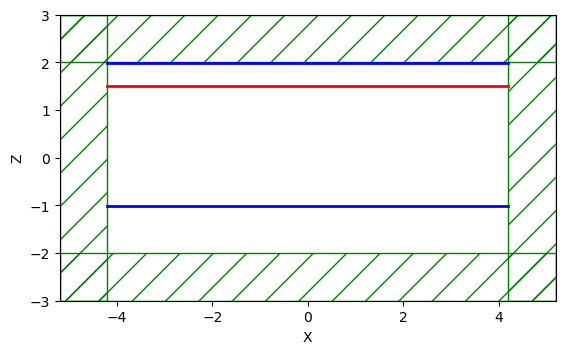

In [10]:
###############################################################################################################################
# ## 4. DFT fields


###############################################################################################################################
# ## 5. Optical Efficiency

# simulation 1 : geometry가 없는 구조
geometry_1 = [
    mp.Block(
        center=mp.Vector3(0, 0, 0), size=mp.Vector3(Sx, Sy, 0), material=Air
    )
]

opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry_1,
    sources=source,
    default_material=Air,
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)
fcen = (1/(0.40 * um_scale) + 1/(0.70 * um_scale))/2
df = 1 /(0.40 * um_scale) - 1/(0.70 * um_scale)
nfreq = 300

beam_x0 = mp.Vector3(0, 0, 0.5)  # beam focus (relative to source center)
rot_angle = 0  # CCW rotation angle about z axis (0: +y axis)
beam_kdir = mp.Vector3(0, 0, -1).rotate(
    mp.Vector3(0, 0, 1), math.radians(rot_angle)
)  # beam propagation direction
beam_w0 = 1  # beam waist radius
beam_E0 = mp.Vector3(1, 1, 0)

sources = [
    mp.GaussianBeam3DSource(
        src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace/2),
        size=mp.Vector3(Sx, Sy, 0),
        beam_x0=beam_x0,
        beam_kdir=beam_kdir,
        beam_w0=beam_w0,
        beam_E0=beam_E0,
    )
]
opt.sim.change_sources(sources)

# reflection moniter 설정

refl_fr = mp.FluxRegion(
    center=mp.Vector3(0, 0, Sz/2 - Lpml - 0.5/resolution), size= mp.Vector3(Sx, Sy, 0)
) 
refl = opt.sim.add_flux(fcen, df, nfreq, refl_fr)

# transmission moiniter 설정

tran_t = mp.FluxRegion(
    center=mp.Vector3(0, 0, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0)
)
tran_total = opt.sim.add_flux(fcen, df, nfreq, tran_t)


# pt는 transmitted flux region과 동일

pt = mp.Vector3(0, 0, -Sz/2 + PDsize - 0.5/resolution)

opt.plot2D(False, output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))

In [11]:
#source가 끝난 후에 50 동안 계속 실행하며 component는 Ey, pt 설계의 끝에서 |Ey|^2의 값이 최대 값으로부터 1/1000 만큼 감쇠할때까지
#추가적인 50 단위의 시간 실행 -> Fourier-transform 수렴예상

opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ex,pt,1e-3))

#데이터 저장

straight_refl_data = opt.sim.get_flux_data(refl)
total_flux = mp.get_fluxes(tran_total)
flux_freqs = mp.get_flux_freqs(tran_total)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000479937 s
Working in 3D dimensions.
Computational cell is 10.4 x 10.4 x 6 with resolution 25
     block, center = (0,0,0)
          size (8.4,8.4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 8.1711 s
-----------
on time step 1 (time=0.02), 8.43929 s/step
on time step 18 (time=0.36), 0.24188 s/step
on time step 36 (time=0.72), 0.229075 s/step
on time step 54 (time=1.08), 0.22934 s/step
on time step 72 (time=1.44), 0.238784 s/step
on time step 90 (time=1.8), 0.231097 s/step
on time step 108 (time=2.16), 0.231596 s/step
on time step 127 (time=2.54), 0.221499 s/step
on time step 145 (time=2.9), 0.226286 s/step
on time step 163 (time=3.26), 0.228357 s/step
on time step 180 (time=3.6), 0.235894 s/step
on time step 198 (time=3.96), 0.230714 s/step
on time step 216 (time=4.32), 0.232247 s/step
on time step 234 (time=4.68), 0.223195 s/step
on t

-----------
Initializing structure...
time for choose_chunkdivision = 0.000730991 s
Working in 3D dimensions.
Computational cell is 10.4 x 10.4 x 6 with resolution 25
     block, center = (0,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,-2.8,0

     block, center = (0,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-2)
          size (8.4,8.4,2)
          axes (1,0,0), (0,1,0), (0,0,1)

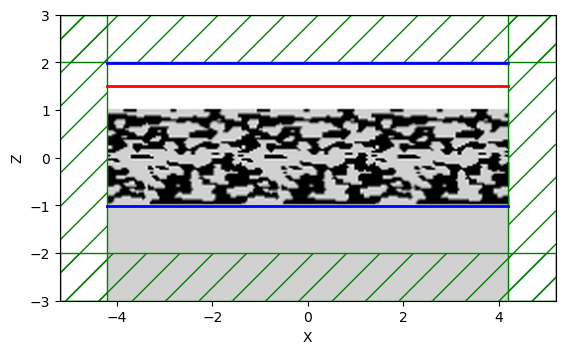

In [12]:
opt.sim.reset_meep()

# simulation 2 : geometry가 있는 구조

opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    default_material=Air,
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

# 반사된 flux 구하기

refl = opt.sim.add_flux(fcen, df, nfreq, refl_fr)

# 투과된 flux 구하기

tran = opt.sim.add_flux(fcen, df, nfreq, tran_t)

#반사된 필드와 입사되는 필드를 구분하기 위해서 The Fourier-transformed incident fields을
#the Fourier transforms of the scattered fields 에서 빼줍니다.

opt.sim.load_minus_flux_data(refl, straight_refl_data)

#각각 픽셀의 flux 구하기

#origin
tran_g = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4, design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_r = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4, -design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_g0 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4, -design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_b = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4, design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)

tran_red = opt.sim.add_flux(fcen, df, nfreq, tran_r)
tran_green = opt.sim.add_flux(fcen, df, nfreq, tran_g)
tran_blue = opt.sim.add_flux(fcen, df, nfreq, tran_b)
tran_green0 = opt.sim.add_flux(fcen, df, nfreq, tran_g0)

#1
tran_g_1 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 - Sx/3, design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_r_1 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 - Sx/3, -design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_g0_1 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 - Sx/3, -design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_b_1 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 - Sx/3, design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)

tran_red_1 = opt.sim.add_flux(fcen, df, nfreq, tran_r_1)
tran_green_1 = opt.sim.add_flux(fcen, df, nfreq, tran_g_1)
tran_blue_1 = opt.sim.add_flux(fcen, df, nfreq, tran_b_1)
tran_green0_1 = opt.sim.add_flux(fcen, df, nfreq, tran_g0_1)
    
#2
tran_g_2 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4, design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_r_2 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4, -design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_g0_2 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4, -design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_b_2 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4, design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)

tran_red_2 = opt.sim.add_flux(fcen, df, nfreq, tran_r_2)
tran_green_2 = opt.sim.add_flux(fcen, df, nfreq, tran_g_2)
tran_blue_2 = opt.sim.add_flux(fcen, df, nfreq, tran_b_2)
tran_green0_2 = opt.sim.add_flux(fcen, df, nfreq, tran_g0_2)
    
#3
tran_g_3 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 + Sx/3, design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_r_3 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 + Sx/3, -design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_g0_3 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 + Sx/3, -design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_b_3 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 + Sx/3, design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)

tran_red_3 = opt.sim.add_flux(fcen, df, nfreq, tran_r_3)
tran_green_3 = opt.sim.add_flux(fcen, df, nfreq, tran_g_3)
tran_blue_3 = opt.sim.add_flux(fcen, df, nfreq, tran_b_3)
tran_green0_3 = opt.sim.add_flux(fcen, df, nfreq, tran_g0_3)
    
#4
tran_g_4 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 - Sx/3, design_region_width_y/4 , -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_r_4 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 - Sx/3, -design_region_width_y/4 , -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_g0_4 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 - Sx/3, -design_region_width_y/4 , -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_b_4 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 - Sx/3, design_region_width_y/4 , -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)

tran_red_4 = opt.sim.add_flux(fcen, df, nfreq, tran_r_4)
tran_green_4 = opt.sim.add_flux(fcen, df, nfreq, tran_g_4)
tran_blue_4 = opt.sim.add_flux(fcen, df, nfreq, tran_b_4)
tran_green0_4 = opt.sim.add_flux(fcen, df, nfreq, tran_g0_4)
    
#5
tran_g_5 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 + Sx/3, design_region_width_y/4 , -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_r_5 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 + Sx/3, -design_region_width_y/4 , -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_g0_5 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 + Sx/3, -design_region_width_y/4 , -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_b_5 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 + Sx/3, design_region_width_y/4 , -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)

tran_red_5 = opt.sim.add_flux(fcen, df, nfreq, tran_r_5)
tran_green_5 = opt.sim.add_flux(fcen, df, nfreq, tran_g_5)
tran_blue_5 = opt.sim.add_flux(fcen, df, nfreq, tran_b_5)
tran_green0_5 = opt.sim.add_flux(fcen, df, nfreq, tran_g0_5)
    
#6
tran_g_6 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 - Sx/3, design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_r_6 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 - Sx/3, -design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_g0_6 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 - Sx/3, -design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_b_6 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 - Sx/3, design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)

tran_red_6 = opt.sim.add_flux(fcen, df, nfreq, tran_r_6)
tran_green_6 = opt.sim.add_flux(fcen, df, nfreq, tran_g_6)
tran_blue_6 = opt.sim.add_flux(fcen, df, nfreq, tran_b_6)
tran_green0_6 = opt.sim.add_flux(fcen, df, nfreq, tran_g0_6)
    
#7
tran_g_7 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 , design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_r_7 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 , -design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_g0_7 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 , -design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_b_7 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 , design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)

tran_red_7 = opt.sim.add_flux(fcen, df, nfreq, tran_r_7)
tran_green_7 = opt.sim.add_flux(fcen, df, nfreq, tran_g_7)
tran_blue_7 = opt.sim.add_flux(fcen, df, nfreq, tran_b_7)
tran_green0_7 = opt.sim.add_flux(fcen, df, nfreq, tran_g0_7)
    
#8
tran_g_8 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 + Sx/3, design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_r_8 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 + Sx/3, -design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_g0_8 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 + Sx/3, -design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_b_8 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 + Sx/3, design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)

tran_red_8 = opt.sim.add_flux(fcen, df, nfreq, tran_r_8)
tran_green_8 = opt.sim.add_flux(fcen, df, nfreq, tran_g_8)
tran_blue_8 = opt.sim.add_flux(fcen, df, nfreq, tran_b_8)
tran_green0_8 = opt.sim.add_flux(fcen, df, nfreq, tran_g0_8)


opt.plot2D(False, output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))

     block, center = (0,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-2)
          size (8.4,8.4,2)
          axes (1,0,0), (0,1,0), (0,0,1)

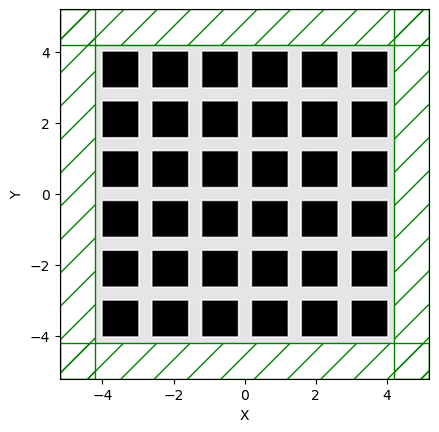

In [13]:
opt.plot2D(False, output_plane = mp.Volume(size = (np.inf, np.inf, 0), center = (0,0,-1)))

In [14]:
opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ex,pt,1e-3))

# 데이터 저장

refl_flux = mp.get_fluxes(refl)
tran_flux = mp.get_fluxes(tran)

red_flux = mp.get_fluxes(tran_red)
green_flux = mp.get_fluxes(tran_green)
blue_flux = mp.get_fluxes(tran_blue)
green_flux0 = mp.get_fluxes(tran_green0)
    
red_flux_1 = mp.get_fluxes(tran_red_1)
green_flux_1 = mp.get_fluxes(tran_green_1)
blue_flux_1 = mp.get_fluxes(tran_blue_1)
green_flux0_1 = mp.get_fluxes(tran_green0_1)
    
red_flux_2 = mp.get_fluxes(tran_red_2)
green_flux_2 = mp.get_fluxes(tran_green_2)
blue_flux_2 = mp.get_fluxes(tran_blue_2)
green_flux0_2 = mp.get_fluxes(tran_green0_2)
    
red_flux_3 = mp.get_fluxes(tran_red_3)
green_flux_3 = mp.get_fluxes(tran_green_3)
blue_flux_3 = mp.get_fluxes(tran_blue_3)
green_flux0_3 = mp.get_fluxes(tran_green0_3)
    
red_flux_4 = mp.get_fluxes(tran_red_4)
green_flux_4 = mp.get_fluxes(tran_green_4)
blue_flux_4 = mp.get_fluxes(tran_blue_4)
green_flux0_4 = mp.get_fluxes(tran_green0_4)
    
red_flux_5 = mp.get_fluxes(tran_red_5)
green_flux_5 = mp.get_fluxes(tran_green_5)
blue_flux_5 = mp.get_fluxes(tran_blue_5)
green_flux0_5 = mp.get_fluxes(tran_green0_5)
    
red_flux_6 = mp.get_fluxes(tran_red_6)
green_flux_6 = mp.get_fluxes(tran_green_6)
blue_flux_6 = mp.get_fluxes(tran_blue_6)
green_flux0_6 = mp.get_fluxes(tran_green0_6)
    
red_flux_7 = mp.get_fluxes(tran_red_7)
green_flux_7 = mp.get_fluxes(tran_green_7)
blue_flux_7 = mp.get_fluxes(tran_blue_7)
green_flux0_7 = mp.get_fluxes(tran_green0_7)
    
red_flux_8 = mp.get_fluxes(tran_red_8)
green_flux_8 = mp.get_fluxes(tran_green_8)
blue_flux_8 = mp.get_fluxes(tran_blue_8)
green_flux0_8 = mp.get_fluxes(tran_green0_8)


on time step 1 (time=0.02), 8.44234 s/step
on time step 17 (time=0.34), 0.258003 s/step
on time step 32 (time=0.64), 0.266676 s/step
on time step 47 (time=0.94), 0.269407 s/step
on time step 61 (time=1.22), 0.290503 s/step
on time step 76 (time=1.52), 0.275874 s/step
on time step 91 (time=1.82), 0.273313 s/step
on time step 107 (time=2.14), 0.261594 s/step
on time step 122 (time=2.44), 0.27984 s/step
on time step 136 (time=2.72), 0.292883 s/step
on time step 150 (time=3), 0.294185 s/step
on time step 164 (time=3.28), 0.299656 s/step
on time step 180 (time=3.6), 0.27475 s/step
on time step 196 (time=3.92), 0.261457 s/step
on time step 211 (time=4.22), 0.271871 s/step
on time step 226 (time=4.52), 0.268717 s/step
on time step 241 (time=4.82), 0.274992 s/step
on time step 256 (time=5.12), 0.271377 s/step
on time step 271 (time=5.42), 0.274533 s/step
on time step 286 (time=5.72), 0.271233 s/step
on time step 301 (time=6.02), 0.27585 s/step
on time step 316 (time=6.32), 0.283136 s/step
on t

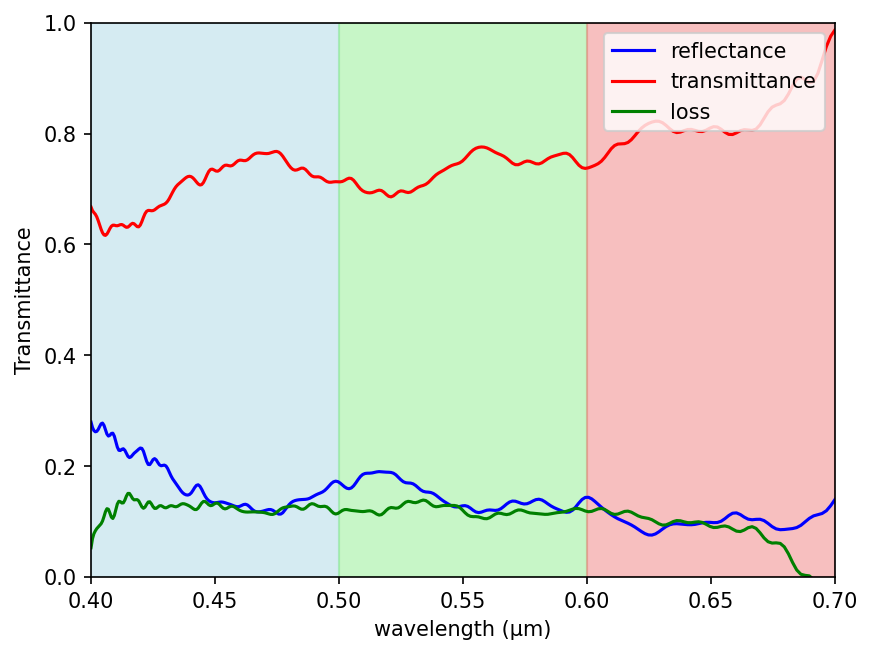

In [15]:
# 투과율과 반사율

wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Rs = np.append(Rs, -refl_flux[i] / total_flux[i])
    Ts = np.append(Ts, tran_flux[i] / total_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "b", label="reflectance")
    plt.plot(wl, Ts, "r", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "g", label="loss")
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="upper right")
    #plt.show()
    plt.savefig(design_dir+"T_R.png")

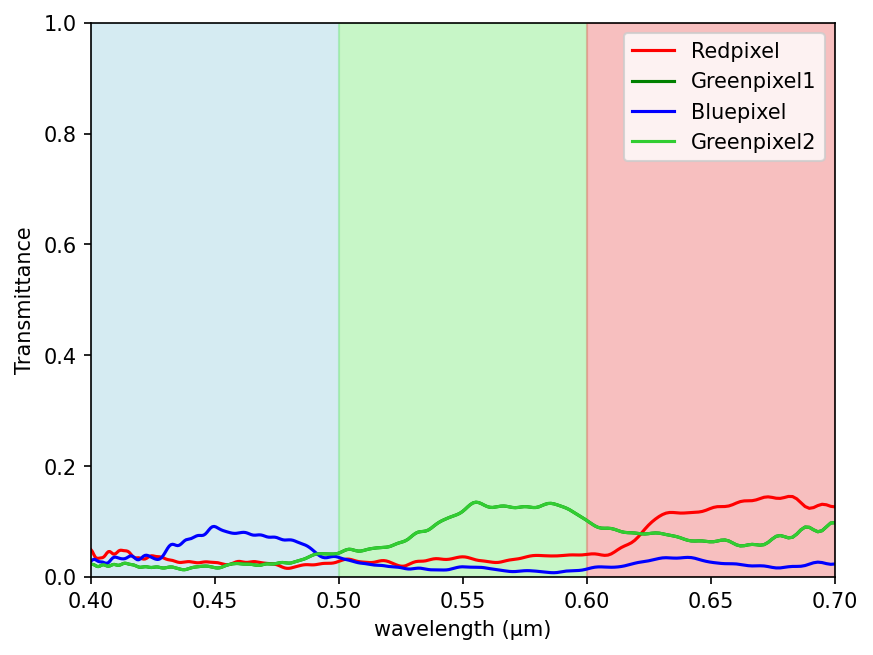

In [16]:
# totalflux 대비 효율

wl = []
Tr = []
Tg = []
Tb = []
Tg0 = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, red_flux[i] / (total_flux[i]))
    Tg = np.append(Tg, green_flux[i] / (total_flux[i]))
    Tb = np.append(Tb, blue_flux[i] / (total_flux[i]))
    Tg0 = np.append(Tg0, green_flux0[i] / (total_flux[i]))

    
if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Tr, "r", label="Redpixel")
    plt.plot(wl, Tg, "g", label="Greenpixel1")
    plt.plot(wl, Tb, "b", label="Bluepixel")
    plt.plot(wl, Tg0, color='limegreen', label="Greenpixel2")
    
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="upper right")
    plt.savefig(design_dir+"TransmissionEfficiency.png")

In [17]:
print(np.mean(Tr[0:66]))
print(np.mean(Tg[66:160]))
print(np.mean(Tg0[66:160]))
print(np.mean(Tb[160:300]))
print(max(Tr[0:66]))
print(max(Tg[66:160]))
print(max(Tg0[66:160]))
print(max(Tb[160:300]))
print(max((Tr - Tg)[0:66]))
print(max((Tg - Tr)[66:160]))
print(max((Tb - Tr)[160:300]))
print(np.mean(Tr[66:300]))
print((sum(Tg[0:66]) + sum(Tg[160:300]))/206)
print(np.mean(Tb[0:160]))

0.10812981177007451
0.09556919240309568
0.09556919240309568
0.05524845901152286
0.1454659502566496
0.13507645000232002
0.1350764500023203
0.09137031000641044
0.0854739181722172
0.10438310021338969
0.06494306321395908
0.030648059549662047
0.0397214468717249
0.019757285741531013


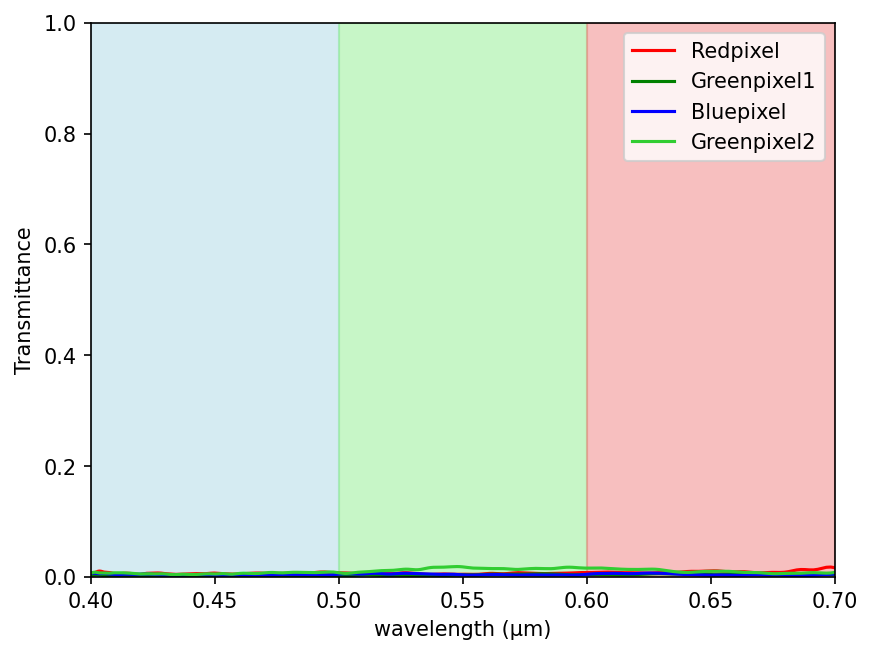

In [18]:
# 1

wl = []
Tr = []
Tg = []
Tb = []
Tg0 = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, red_flux_1[i] / (total_flux[i]))
    Tg = np.append(Tg, green_flux_1[i] / (total_flux[i]))
    Tb = np.append(Tb, blue_flux_1[i] / (total_flux[i]))
    Tg0 = np.append(Tg0, green_flux0_1[i] / (total_flux[i]))

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Tr, "r", label="Redpixel")
    plt.plot(wl, Tg, "g", label="Greenpixel1")
    plt.plot(wl, Tb, "b", label="Bluepixel")
    plt.plot(wl, Tg0, color='limegreen', label="Greenpixel2")
    
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="upper right")
    plt.savefig(design_dir+"TransmissionEfficiency.png")

In [19]:
print(np.mean(Tr[0:66]))
print(np.mean(Tg[66:160]))
print(np.mean(Tg0[66:160]))
print(np.mean(Tb[160:300]))
print(max(Tr[0:66]))
print(max(Tg[66:160]))
print(max(Tg0[66:160]))
print(max(Tb[160:300]))
print(max((Tr - Tg)[0:66]))
print(max((Tg - Tr)[66:160]))
print(max((Tb - Tr)[160:300]))
print(np.mean(Tr[66:300]))
print((sum(Tg[0:66]) + sum(Tg[160:300]))/206)
print(np.mean(Tb[0:160]))

0.009781649966927944
0.004074738001689644
0.014252978636708023
0.004519959242200083
0.018100208330348606
0.0058892165971757525
0.018979939587991636
0.007215021712758412
0.013703448293741708
-0.00041607499975609454
0.0007298123619291098
0.006591388856251254
0.0032510517999740185
0.004938240238404912


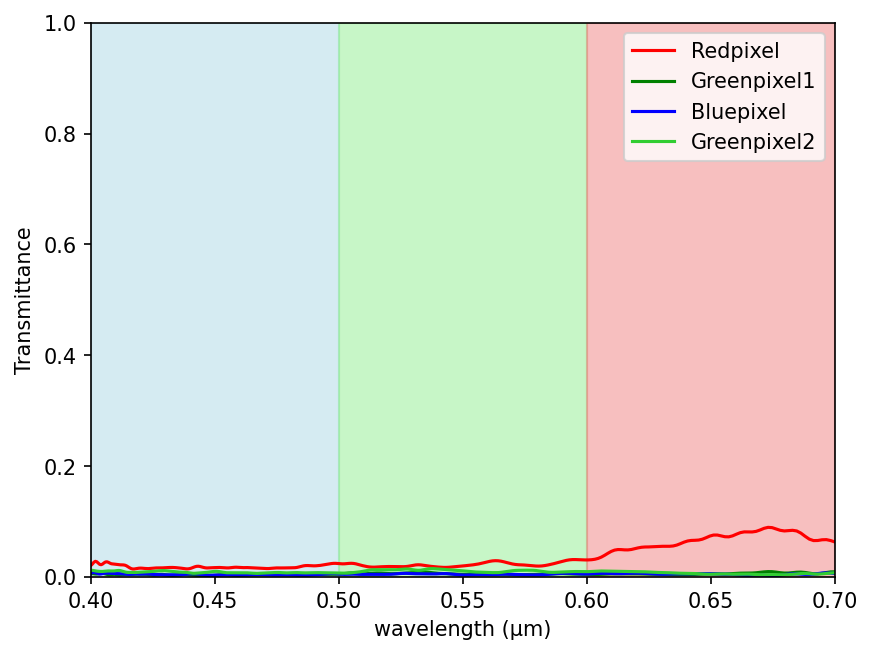

In [20]:
# 2

wl = []
Tr = []
Tg = []
Tb = []
Tg0 = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, red_flux_2[i] / (total_flux[i]))
    Tg = np.append(Tg, green_flux_2[i] / (total_flux[i]))
    Tb = np.append(Tb, blue_flux_2[i] / (total_flux[i]))
    Tg0 = np.append(Tg0, green_flux0_2[i] / (total_flux[i]))

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Tr, "r", label="Redpixel")
    plt.plot(wl, Tg, "g", label="Greenpixel1")
    plt.plot(wl, Tb, "b", label="Bluepixel")
    plt.plot(wl, Tg0, color='limegreen', label="Greenpixel2")
    
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="upper right")
    plt.savefig(design_dir+"TransmissionEfficiency.png")

In [21]:
print(np.mean(Tr[0:66]))
print(np.mean(Tg[66:160]))
print(np.mean(Tg0[66:160]))
print(np.mean(Tb[160:300]))
print(max(Tr[0:66]))
print(max(Tg[66:160]))
print(max(Tg0[66:160]))
print(max(Tb[160:300]))
print(max((Tr - Tg)[0:66]))
print(max((Tg - Tr)[66:160]))
print(max((Tb - Tr)[160:300]))
print(np.mean(Tr[66:300]))
print((sum(Tg[0:66]) + sum(Tg[160:300]))/206)
print(np.mean(Tb[0:160]))

0.06476828406435937
0.006106859250762208
0.011162500314814772
0.0048751089429982615
0.08969580373409529
0.008920618241730918
0.015263848390671374
0.008451370238449397
0.07981730343043554
-0.010745208532288587
-0.00906143960057473
0.02018768719918707
0.005028880481256125
0.0053434505072382735


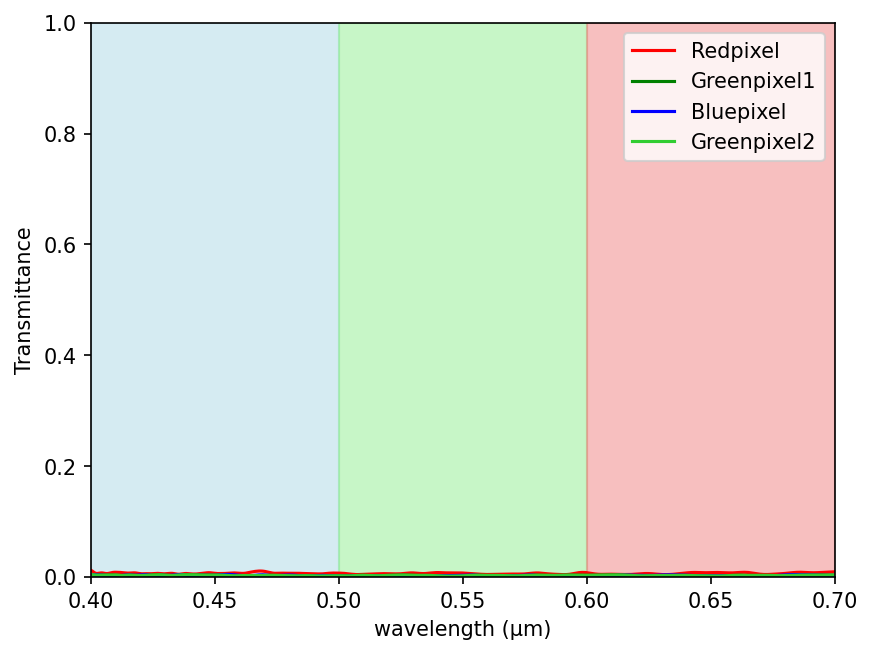

In [22]:
# 3

wl = []
Tr = []
Tg = []
Tb = []
Tg0 = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, red_flux_3[i] / (total_flux[i]))
    Tg = np.append(Tg, green_flux_3[i] / (total_flux[i]))
    Tb = np.append(Tb, blue_flux_3[i] / (total_flux[i]))
    Tg0 = np.append(Tg0, green_flux0_3[i] / (total_flux[i]))

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Tr, "r", label="Redpixel")
    plt.plot(wl, Tg, "g", label="Greenpixel1")
    plt.plot(wl, Tb, "b", label="Bluepixel")
    plt.plot(wl, Tg0, color='limegreen', label="Greenpixel2")
    
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="upper right")
    plt.savefig(design_dir+"TransmissionEfficiency.png")

In [23]:
print(np.mean(Tr[0:66]))
print(np.mean(Tg[66:160]))
print(np.mean(Tg0[66:160]))
print(np.mean(Tb[160:300]))
print(max(Tr[0:66]))
print(max(Tg[66:160]))
print(max(Tg0[66:160]))
print(max(Tb[160:300]))
print(max((Tr - Tg)[0:66]))
print(max((Tg - Tr)[66:160]))
print(max((Tb - Tr)[160:300]))
print(np.mean(Tr[66:300]))
print((sum(Tg[0:66]) + sum(Tg[160:300]))/206)
print(np.mean(Tb[0:160]))

0.0066608906304682185
0.0028733618351242363
0.0028733618351242363
0.0031708658000565416
0.009569594622298288
0.00371341913749854
0.0037134191374985394
0.004802520327207783
0.0064002357782434825
-0.0011675317568628765
-0.0010096672064345636
0.006717960064581806
0.0031062012333974115
0.0025909449863939595


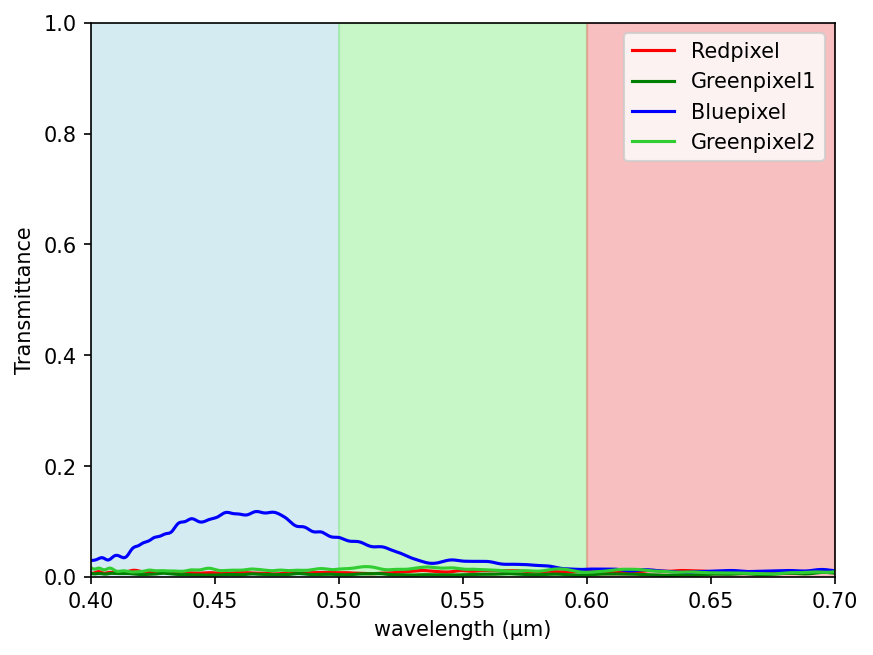

In [24]:
# 4

wl = []
Tr = []
Tg = []
Tb = []
Tg0 = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, red_flux_4[i] / (total_flux[i]))
    Tg = np.append(Tg, green_flux_4[i] / (total_flux[i]))
    Tb = np.append(Tb, blue_flux_4[i] / (total_flux[i]))
    Tg0 = np.append(Tg0, green_flux0_4[i] / (total_flux[i]))

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Tr, "r", label="Redpixel")
    plt.plot(wl, Tg, "g", label="Greenpixel1")
    plt.plot(wl, Tb, "b", label="Bluepixel")
    plt.plot(wl, Tg0, color='limegreen', label="Greenpixel2")
    
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="upper right")
    plt.savefig(design_dir+"TransmissionEfficiency.png")

In [25]:
print(np.mean(Tr[0:66]))
print(np.mean(Tg[66:160]))
print(np.mean(Tg0[66:160]))
print(np.mean(Tb[160:300]))
print(max(Tr[0:66]))
print(max(Tg[66:160]))
print(max(Tg0[66:160]))
print(max(Tb[160:300]))
print(max((Tr - Tg)[0:66]))
print(max((Tg - Tr)[66:160]))
print(max((Tb - Tr)[160:300]))
print(np.mean(Tr[66:300]))
print((sum(Tg[0:66]) + sum(Tg[160:300]))/206)
print(np.mean(Tb[0:160]))

0.009033009573757295
0.004696100785655934
0.014212377217412343
0.08237015776596805
0.012070001109434209
0.006246738899965336
0.01884644541100445
0.11829510459455574
0.008156052453375398
-3.0482077086161317e-05
0.11127701734093975
0.008748022350126717
0.005162489283172285
0.0248561677654282


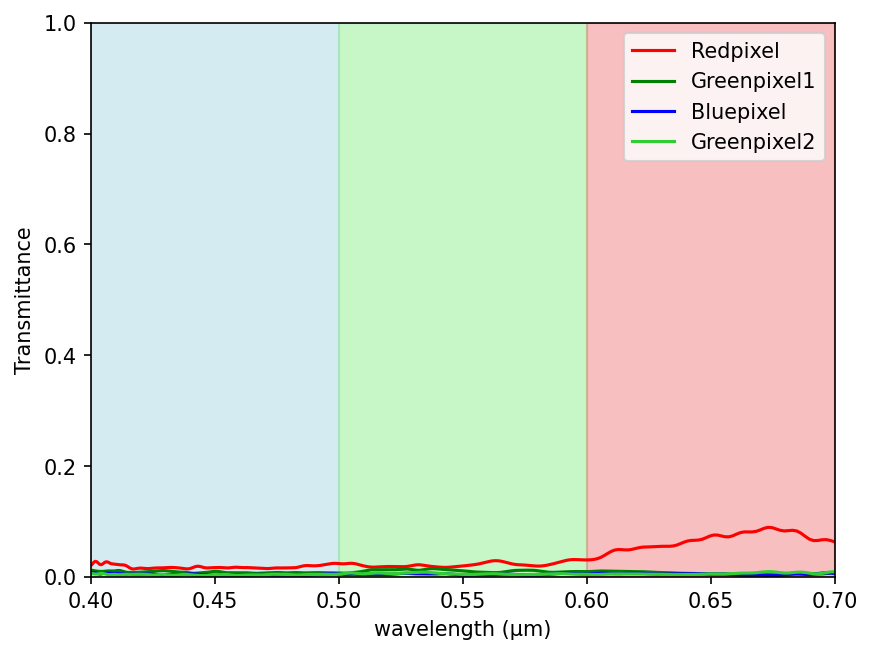

In [26]:
# 5

wl = []
Tr = []
Tg = []
Tb = []
Tg0 = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, red_flux_5[i] / (total_flux[i]))
    Tg = np.append(Tg, green_flux_5[i] / (total_flux[i]))
    Tb = np.append(Tb, blue_flux_5[i] / (total_flux[i]))
    Tg0 = np.append(Tg0, green_flux0_5[i] / (total_flux[i]))

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Tr, "r", label="Redpixel")
    plt.plot(wl, Tg, "g", label="Greenpixel1")
    plt.plot(wl, Tb, "b", label="Bluepixel")
    plt.plot(wl, Tg0, color='limegreen', label="Greenpixel2")
    
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="upper right")
    plt.savefig(design_dir+"TransmissionEfficiency.png")

In [27]:
print(np.mean(Tr[0:66]))
print(np.mean(Tg[66:160]))
print(np.mean(Tg0[66:160]))
print(np.mean(Tb[160:300]))
print(max(Tr[0:66]))
print(max(Tg[66:160]))
print(max(Tg0[66:160]))
print(max(Tb[160:300]))
print(max((Tr - Tg)[0:66]))
print(max((Tg - Tr)[66:160]))
print(max((Tb - Tr)[160:300]))
print(np.mean(Tr[66:300]))
print((sum(Tg[0:66]) + sum(Tg[160:300]))/206)
print(np.mean(Tb[0:160]))

0.06476828406435939
0.01116250031481477
0.006106859250762208
0.004875108942998262
0.08969580373409544
0.015263848390671356
0.008920618241730925
0.008451370238449444
0.0854535189086996
-0.0034328828411872327
-0.009061439600574756
0.020187687199187072
0.008327009700185064
0.005343450507238277


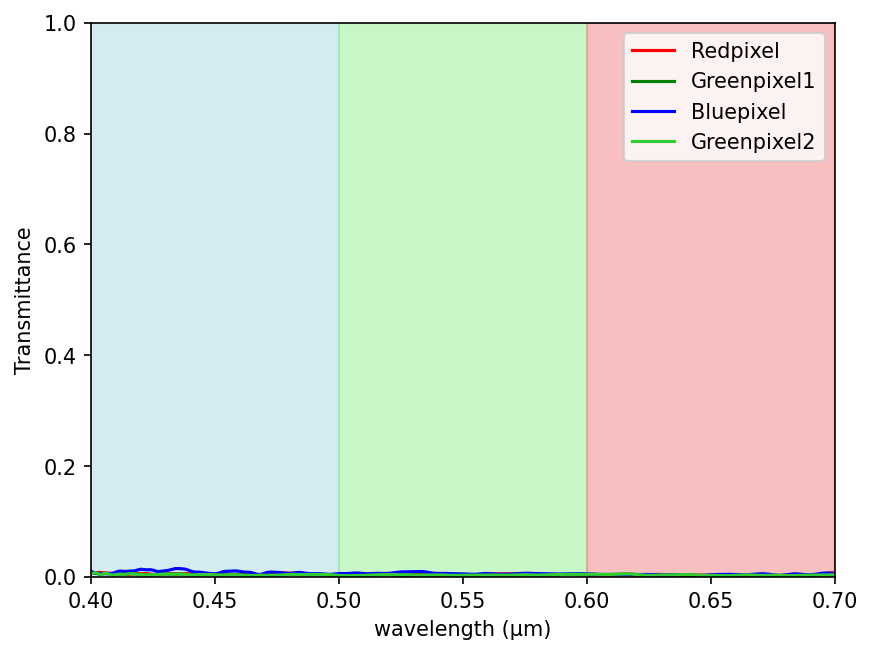

In [28]:
# 6

wl = []
Tr = []
Tg = []
Tb = []
Tg0 = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, red_flux_6[i] / (total_flux[i]))
    Tg = np.append(Tg, green_flux_6[i] / (total_flux[i]))
    Tb = np.append(Tb, blue_flux_6[i] / (total_flux[i]))
    Tg0 = np.append(Tg0, green_flux0_6[i] / (total_flux[i]))

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Tr, "r", label="Redpixel")
    plt.plot(wl, Tg, "g", label="Greenpixel1")
    plt.plot(wl, Tb, "b", label="Bluepixel")
    plt.plot(wl, Tg0, color='limegreen', label="Greenpixel2")
    
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="upper right")
    plt.savefig(design_dir+"TransmissionEfficiency.png")

In [29]:
print(np.mean(Tr[0:66]))
print(np.mean(Tg[66:160]))
print(np.mean(Tg0[66:160]))
print(np.mean(Tb[160:300]))
print(max(Tr[0:66]))
print(max(Tg[66:160]))
print(max(Tg0[66:160]))
print(max(Tb[160:300]))
print(max((Tr - Tg)[0:66]))
print(max((Tg - Tr)[66:160]))
print(max((Tb - Tr)[160:300]))
print(np.mean(Tr[66:300]))
print((sum(Tg[0:66]) + sum(Tg[160:300]))/206)
print(np.mean(Tb[0:160]))

0.003738181398408912
0.0038082104354724188
0.0038082104354724188
0.009166244344494694
0.007961995233607109
0.004956688992665573
0.0049566889926655686
0.015411742962117088
0.004049992251671369
0.0016176363626487782
0.009005917507742673
0.005212440510777261
0.004349543220249689
0.005801940860130798


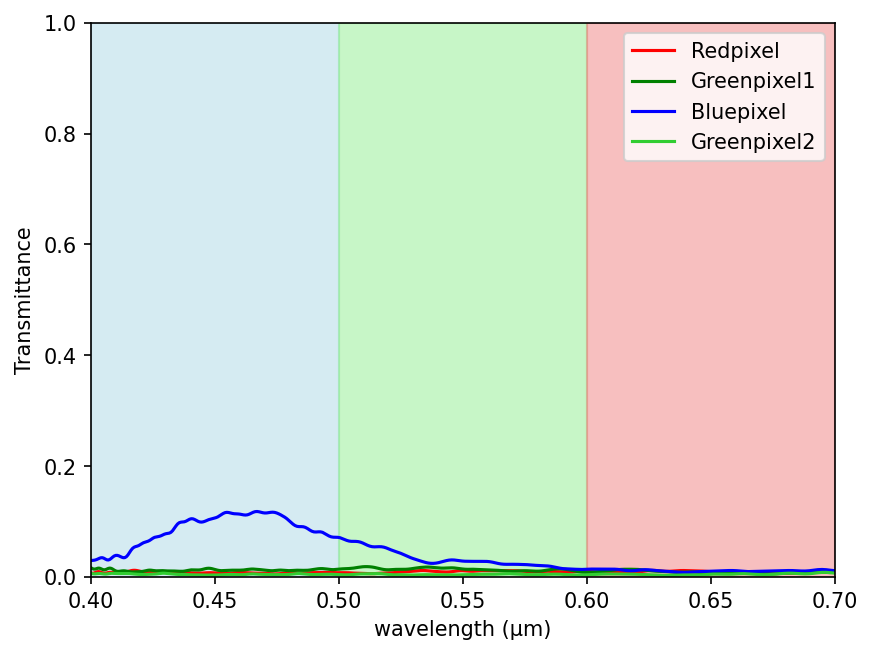

In [30]:
# 7

wl = []
Tr = []
Tg = []
Tb = []
Tg0 = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, red_flux_7[i] / (total_flux[i]))
    Tg = np.append(Tg, green_flux_7[i] / (total_flux[i]))
    Tb = np.append(Tb, blue_flux_7[i] / (total_flux[i]))
    Tg0 = np.append(Tg0, green_flux0_7[i] / (total_flux[i]))

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Tr, "r", label="Redpixel")
    plt.plot(wl, Tg, "g", label="Greenpixel1")
    plt.plot(wl, Tb, "b", label="Bluepixel")
    plt.plot(wl, Tg0, color='limegreen', label="Greenpixel2")
    
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="upper right")
    plt.savefig(design_dir+"TransmissionEfficiency.png")

In [31]:
print(np.mean(Tr[0:66]))
print(np.mean(Tg[66:160]))
print(np.mean(Tg0[66:160]))
print(np.mean(Tb[160:300]))
print(max(Tr[0:66]))
print(max(Tg[66:160]))
print(max(Tg0[66:160]))
print(max(Tb[160:300]))
print(max((Tr - Tg)[0:66]))
print(max((Tg - Tr)[66:160]))
print(max((Tb - Tr)[160:300]))
print(np.mean(Tr[66:300]))
print((sum(Tg[0:66]) + sum(Tg[160:300]))/206)
print(np.mean(Tb[0:160]))

0.009033009573757283
0.014212377217412343
0.0046961007856559335
0.08237015776596804
0.012070001109434202
0.018846445411004456
0.0062467388999653374
0.11829510459455571
0.0031953824804373653
0.012508968334832046
0.11127701734093973
0.008748022350126717
0.011495786163786334
0.0248561677654282


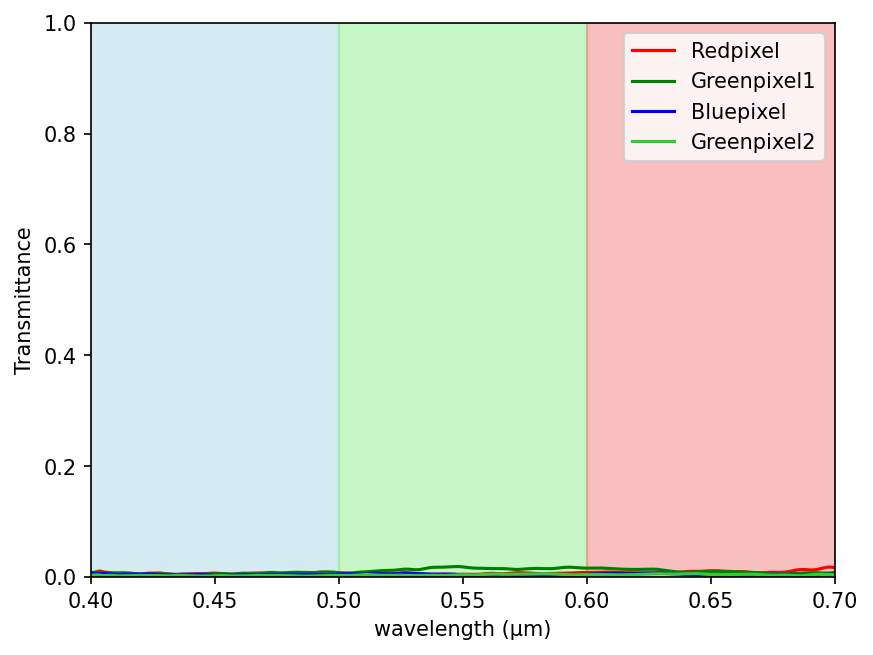

In [32]:
# 8

wl = []
Tr = []
Tg = []
Tb = []
Tg0 = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, red_flux_8[i] / (total_flux[i]))
    Tg = np.append(Tg, green_flux_8[i] / (total_flux[i]))
    Tb = np.append(Tb, blue_flux_8[i] / (total_flux[i]))
    Tg0 = np.append(Tg0, green_flux0_8[i] / (total_flux[i]))

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Tr, "r", label="Redpixel")
    plt.plot(wl, Tg, "g", label="Greenpixel1")
    plt.plot(wl, Tb, "b", label="Bluepixel")
    plt.plot(wl, Tg0, color='limegreen', label="Greenpixel2")
    
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="upper right")
    plt.savefig(design_dir+"TransmissionEfficiency.png")

In [33]:
print(np.mean(Tr[0:66]))
print(np.mean(Tg[66:160]))
print(np.mean(Tg0[66:160]))
print(np.mean(Tb[160:300]))
print(max(Tr[0:66]))
print(max(Tg[66:160]))
print(max(Tg0[66:160]))
print(max(Tb[160:300]))
print(max((Tr - Tg)[0:66]))
print(max((Tg - Tr)[66:160]))
print(max((Tb - Tr)[160:300]))
print(np.mean(Tr[66:300]))
print((sum(Tg[0:66]) + sum(Tg[160:300]))/206)
print(np.mean(Tb[0:160]))

0.009781649966927935
0.014252978636708028
0.004074738001689644
0.004519959242200084
0.01810020833034859
0.01897993958799165
0.005889216597175762
0.007215021712758422
0.010675409035113288
0.013963970632469288
0.0007298123619290907
0.006591388856251252
0.00798852601634391
0.004938240238404911


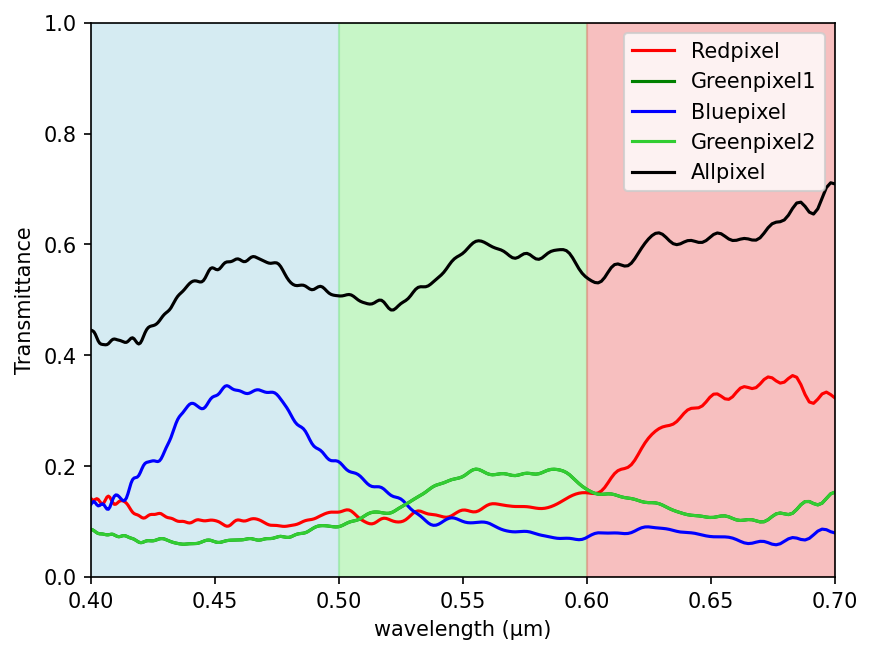

In [34]:
#sum
wl = []
Tr = []
Tg = []
Tb = []
Tg0 = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, (red_flux[i]+red_flux_1[i]+red_flux_2[i]+red_flux_3[i]+red_flux_4[i]+red_flux_5[i]+red_flux_6[i]+red_flux_7[i]+red_flux_8[i]) / (total_flux[i]))
    Tg = np.append(Tg, (green_flux[i]+green_flux_1[i]+green_flux_2[i]+green_flux_3[i]+green_flux_4[i]+green_flux_5[i]+green_flux_6[i]+green_flux_7[i]+green_flux_8[i]) / (total_flux[i]))
    Tg0 = np.append(Tg0, (green_flux0[i]+green_flux0_1[i]+green_flux0_2[i]+green_flux0_3[i]+green_flux0_4[i]+green_flux0_5[i]+green_flux0_6[i]+green_flux0_7[i]+green_flux0_8[i]) / (total_flux[i]))
    Tb = np.append(Tb, (blue_flux[i]+blue_flux_1[i]+blue_flux_2[i]+blue_flux_3[i]+blue_flux_4[i]+blue_flux_5[i]+blue_flux_6[i]+blue_flux_7[i]+blue_flux_8[i]) / (total_flux[i]))
    s = Tr+Tg+Tb+Tg0

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Tr, "r", label="Redpixel")
    plt.plot(wl, Tg, "g", label="Greenpixel1")
    plt.plot(wl, Tb, "b", label="Bluepixel")
    plt.plot(wl, Tg0, color='limegreen', label="Greenpixel2")
    plt.plot(wl, s,  "k", label="Allpixel")
    
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="upper right")
    plt.savefig(design_dir+"AllTransmission.png")

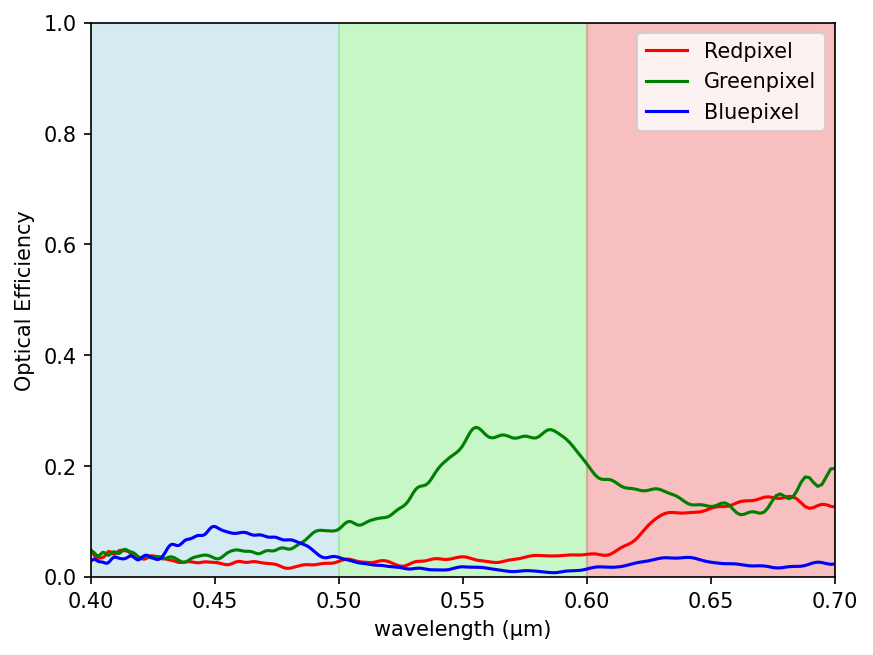

In [35]:
# 입사 flux 대비 효율

wl = []
Tr = []
Tg = []
Tb = []
Tg0 = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, red_flux[i] / (total_flux[i]))
    Tg = np.append(Tg, green_flux[i] / (total_flux[i]))
    Tb = np.append(Tb, blue_flux[i] / (total_flux[i]))
    Tg0 = np.append(Tg0, green_flux0[i] / (total_flux[i]))

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Tr, "r", label="Redpixel")
    plt.plot(wl, Tg+Tg0, "g", label="Greenpixel")
    plt.plot(wl, Tb, "b", label="Bluepixel")
    #plt.plot(wl, Tg0, color='limegreen', label="Greenpixel2")
    
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Optical Efficiency")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="upper right")
    #plt.show()
    plt.savefig(design_dir+"Optical Efficiency.png")

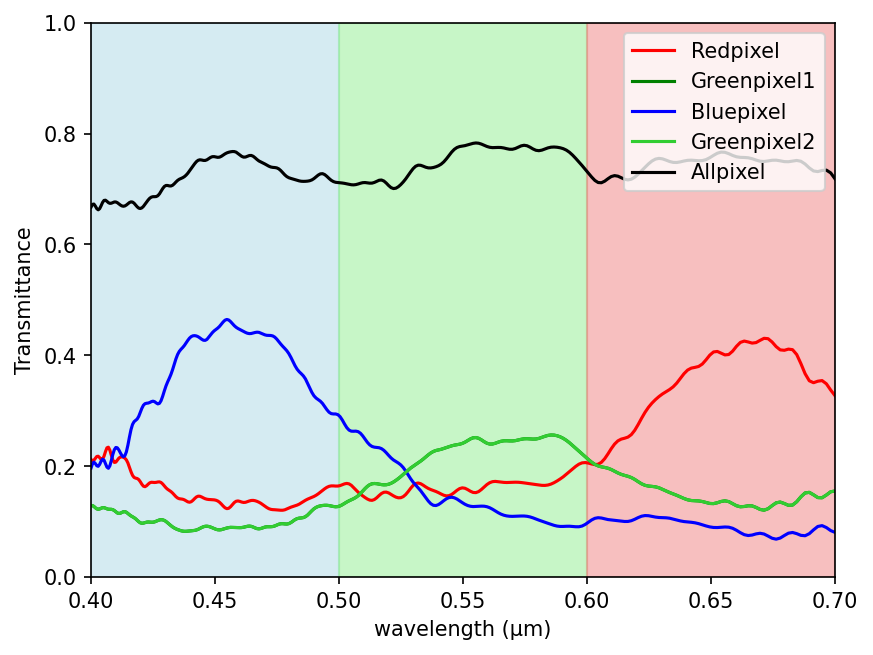

In [36]:
#sum
wl = []
Tr = []
Tg = []
Tb = []
Tg0 = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, (red_flux[i]+red_flux_1[i]+red_flux_2[i]+red_flux_3[i]+red_flux_4[i]+red_flux_5[i]+red_flux_6[i]+red_flux_7[i]+red_flux_8[i]) / (tran_flux[i]))
    Tg = np.append(Tg, (green_flux[i]+green_flux_1[i]+green_flux_2[i]+green_flux_3[i]+green_flux_4[i]+green_flux_5[i]+green_flux_6[i]+green_flux_7[i]+green_flux_8[i]) / (tran_flux[i]))
    Tg0 = np.append(Tg0, (green_flux0[i]+green_flux0_1[i]+green_flux0_2[i]+green_flux0_3[i]+green_flux0_4[i]+green_flux0_5[i]+green_flux0_6[i]+green_flux0_7[i]+green_flux0_8[i]) / (tran_flux[i]))
    Tb = np.append(Tb, (blue_flux[i]+blue_flux_1[i]+blue_flux_2[i]+blue_flux_3[i]+blue_flux_4[i]+blue_flux_5[i]+blue_flux_6[i]+blue_flux_7[i]+blue_flux_8[i]) / (tran_flux[i]))
    s = Tr+Tg+Tb+Tg0

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Tr, "r", label="Redpixel")
    plt.plot(wl, Tg, "g", label="Greenpixel1")
    plt.plot(wl, Tb, "b", label="Bluepixel")
    plt.plot(wl, Tg0, color='limegreen', label="Greenpixel2")
    plt.plot(wl, s,  "k", label="Allpixel")
    
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.ylabel("Transmittance")
    plt.fill([0.40, 0.40, 0.50, 0.50], [0.0, 1.0, 1.0, 0.0], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [0.0, 1.0, 1.0, 0.0], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [0.0, 1.0, 1.0, 0.0], color='lightcoral', alpha=0.5)
    plt.legend(loc="upper right")
    plt.savefig(design_dir+"AllOpticalEffeciency.png")

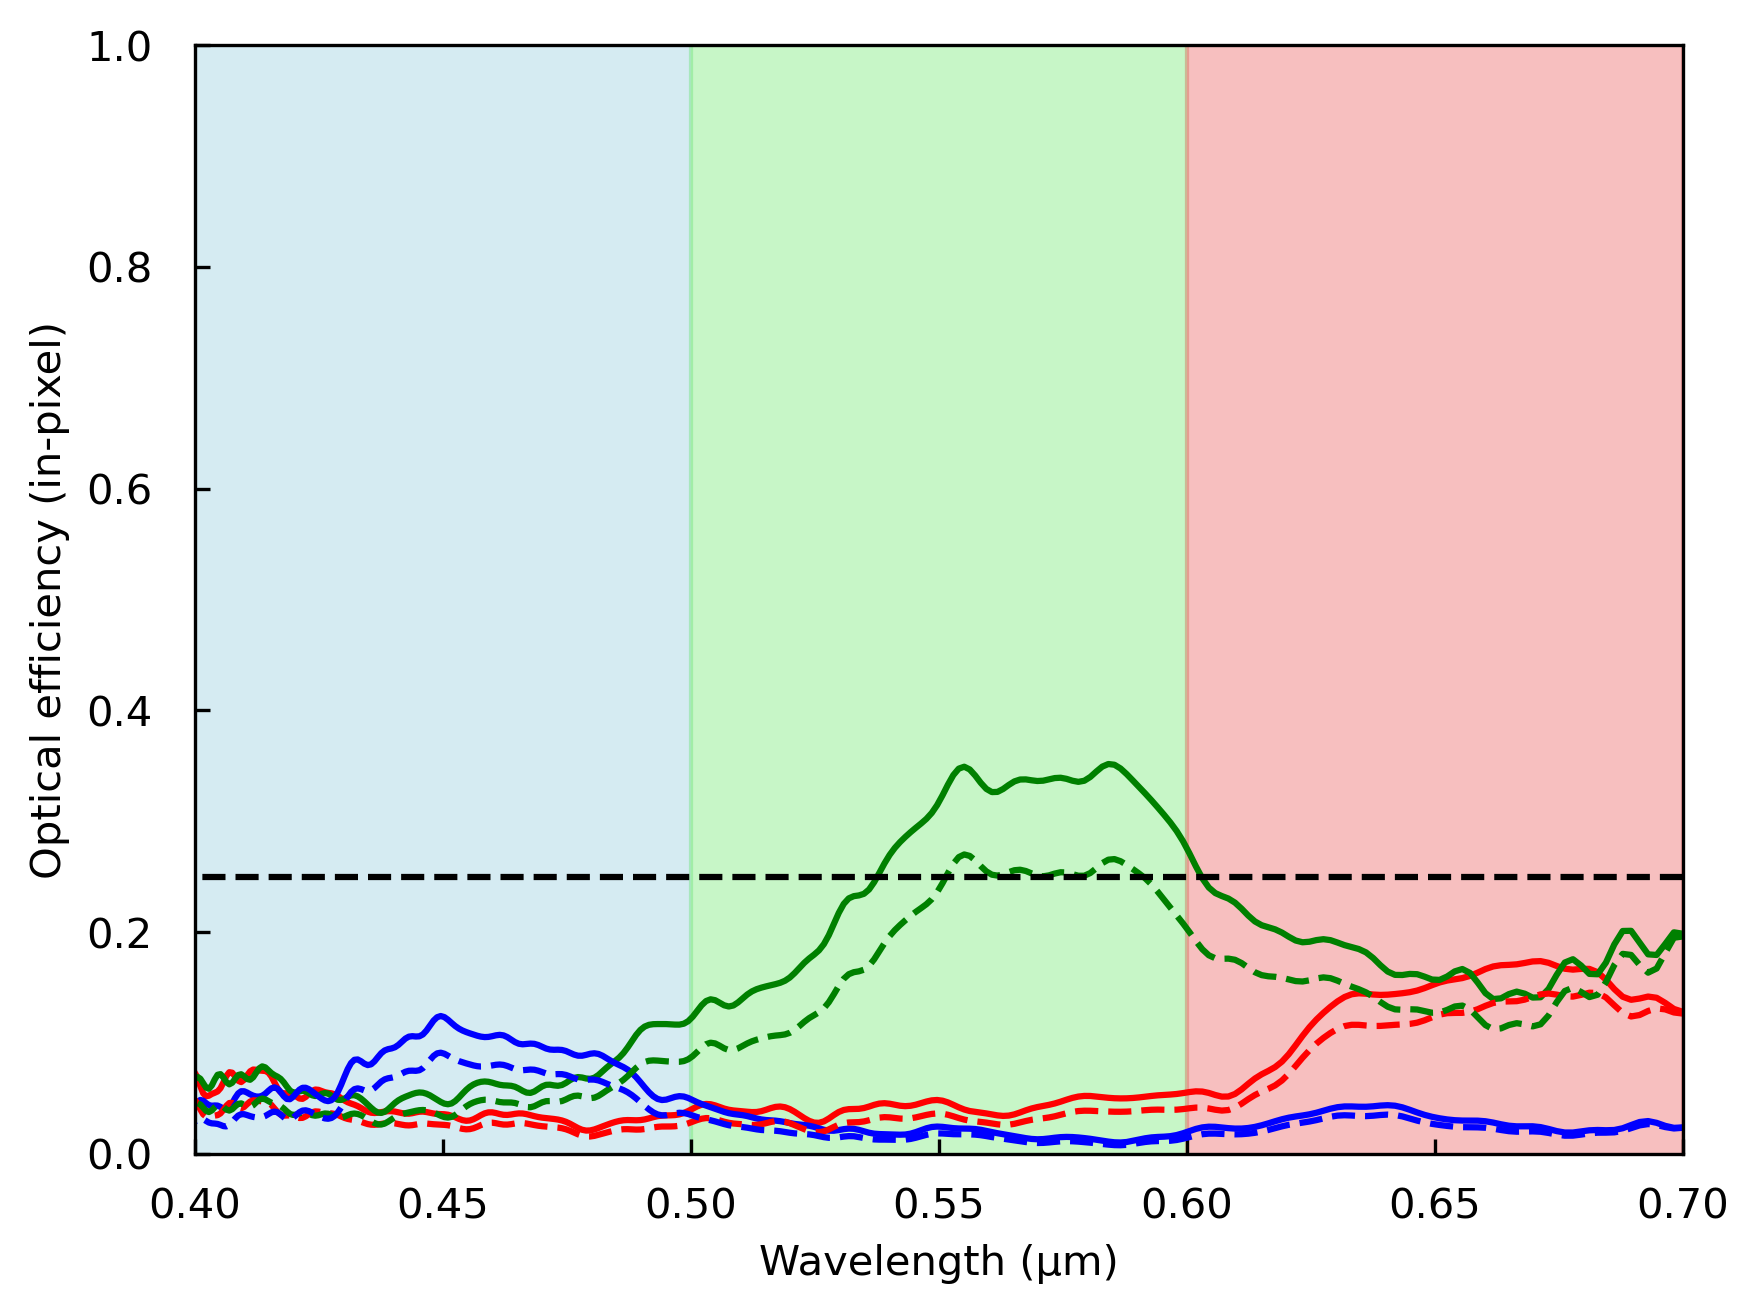

In [37]:
# 입사 flux 대비 효율

wl = []
Tr = []
Tg = []
Tb = []
Tg0 = []

Trt = []
Tgt = []
Tbt = []
Tg0t = []
convenional=[]
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Tr = np.append(Tr, red_flux[i] / tran_flux[i])
    Tg = np.append(Tg, green_flux[i] /tran_flux[i])
    Tb = np.append(Tb, blue_flux[i] / tran_flux[i])
    Tg0 = np.append(Tg0, green_flux0[i] / tran_flux[i])

    Trt = np.append(Trt, red_flux[i] / total_flux[i])
    Tgt = np.append(Tgt, green_flux[i] / total_flux[i])
    Tbt = np.append(Tbt, blue_flux[i] / total_flux[i])
    Tg0t = np.append(Tg0t, green_flux0[i] / total_flux[i])

    convenional = np.append(convenional,0.25)
if mp.am_master():
    plt.figure(dpi=300)
    plt.plot(wl, Tr, "r",)
    plt.plot(wl, Tg+Tg0, "g",)
    plt.plot(wl, Tb, "b",)
    plt.plot(wl, Trt, "r--",)
    plt.plot(wl, Tgt+Tg0t, "g--",)
    plt.plot(wl, Tbt, "b--",)
    plt.plot(wl, convenional, 'k--')
    
    plt.axis([0.40, 0.70, 0.0, 1.0])
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Optical efficiency (in-pixel)")
    plt.fill([0.40, 0.40, 0.50, 0.50], [-0.03, 1.03, 1.03, -0.03], color='lightblue', alpha=0.5)
    plt.fill([0.50, 0.50, 0.60, 0.60], [-0.03, 1.03, 1.03, -0.03], color='lightgreen', alpha=0.5)
    plt.fill([0.60, 0.60, 0.70, 0.70], [-0.03, 1.03, 1.03, -0.03], color='lightcoral', alpha=0.5)
    plt.tick_params(axis='x', direction='in', pad = 8)
    plt.tick_params(axis='y', direction='in', pad = 10)
    #plt.show()
    plt.savefig(design_dir+"Optical Efficiency.png")

In [38]:
print(np.mean(Tr[0:66]))
print(np.mean(Tg[66:160]))
print(np.mean(Tb[160:300]))
print(max(Tr[0:66]))
print(max(Tg[66:160]))
print(max(Tb[160:300]))
print(max((Tr - Tg)[0:66]))
print(max((Tg - Tr)[66:160]))
print(max((Tb - Tr)[160:300]))
print(np.mean(Tr[66:300]))
print((sum(Tg[0:66]) + sum(Tg[160:300]))/206)
print(np.mean(Tb[0:160]))

0.13020858203890195
0.12931888986165707
0.07741743978869295
0.17396559930445868
0.17585987698919214
0.12443573993195235
0.10329039530755486
0.13465891299924934
0.08844490211218045
0.043440349345603146
0.05161077170289531
0.025630922915635374


     block, center = (0,0,0)
          size (8.4,8.4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


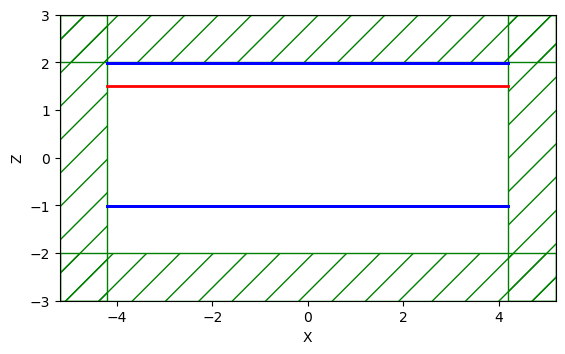

In [39]:
# ## 5. Optical Efficiency

# simulation 1 : geometry가 없는 구조
geometry_1 = [
    mp.Block(
        center=mp.Vector3(0, 0, 0), size=mp.Vector3(Sx, Sy, 0), material=Air
    )
]

opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry_1,
    sources=source,
    default_material=Air,
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)
fcen = (1/(0.40 * um_scale) + 1/(0.70 * um_scale))/2
df = 1 /(0.40 * um_scale) - 1/(0.70 * um_scale)
nfreq = 300

beam_x0 = mp.Vector3(0, 0, 0.5)  # beam focus (relative to source center)
rot_angle = 0  # CCW rotation angle about z axis (0: +y axis)
beam_kdir = mp.Vector3(0, 0, -1).rotate(
    mp.Vector3(0, 0, 1), math.radians(rot_angle)
)  # beam propagation direction
beam_w0 = 1  # beam waist radius
beam_E0 = mp.Vector3(1, 1, 0)

sources = [
    mp.GaussianBeam3DSource(
        src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace/2),
        size=mp.Vector3(Sx, Sy, 0),
        beam_x0=beam_x0,
        beam_kdir=beam_kdir,
        beam_w0=beam_w0,
        beam_E0=beam_E0,
    )
]
opt.sim.change_sources(sources)

#moniter 설정
refl = []
tran_total = []
straight_refl_data = []
total_flux = []
flux_freqs = []

refl_fr = mp.FluxRegion(
    center=mp.Vector3(0, 0, Sz/2 - Lpml - 0.5/resolution), size= mp.Vector3(Sx, Sy, 0)
) 

# transmission moiniter 설정

tran_t = mp.FluxRegion(
    center=mp.Vector3(0, 0, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(Sx, Sy, 0)
)

for i in range(31):
    refl = np.append(refl, opt.sim.add_flux(1/wavelengths[i], 0, 1, refl_fr))
    tran_total = np.append(tran_total, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_t))
    
# pt는 transmitted flux region과 동일

pt = mp.Vector3(0, 0, -Sz/2 + PDsize - 0.5/resolution)

opt.plot2D(False, output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))

In [40]:
opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ex,pt,1e-3))

#데이터 저장


for i in range(31):
    straight_refl_data =  np.append(straight_refl_data,mp.get_fluxes(refl[i]))
    total_flux = np.append(total_flux,mp.get_fluxes(tran_total[i]))
    flux_freqs = np.append(flux_freqs,mp.get_flux_freqs(tran_total[i]))

-----------
Initializing structure...
time for choose_chunkdivision = 0.000467062 s
Working in 3D dimensions.
Computational cell is 10.4 x 10.4 x 6 with resolution 25
     block, center = (0,0,0)
          size (8.4,8.4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 8.33682 s
-----------
on time step 1 (time=0.02), 8.47584 s/step
on time step 19 (time=0.38), 0.226045 s/step
on time step 37 (time=0.74), 0.228725 s/step
on time step 55 (time=1.1), 0.223988 s/step
on time step 73 (time=1.46), 0.228195 s/step
on time step 91 (time=1.82), 0.225312 s/step
on time step 110 (time=2.2), 0.219252 s/step
on time step 129 (time=2.58), 0.220967 s/step
on time step 147 (time=2.94), 0.222712 s/step
on time step 165 (time=3.3), 0.223038 s/step
on time step 183 (time=3.66), 0.224019 s/step
on time step 201 (time=4.02), 0.225159 s/step
on time step 220 (time=4.4), 0.222948 s/step
on time step 238 (time=4.76), 0.223934 s/step
on

     block, center = (0,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-2)
          size (8.4,8.4,2)
          axes (1,0,0), (0,1,0), (0,0,1)

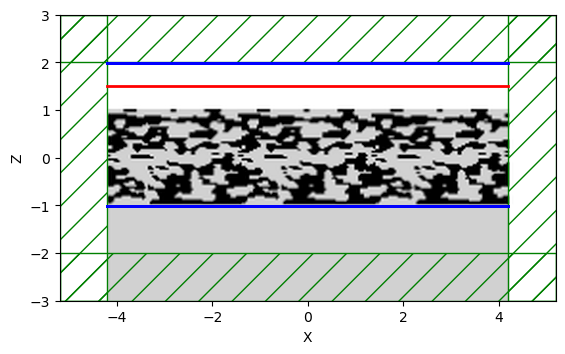

In [41]:
opt.sim.reset_meep()

# simulation 2 : geometry가 있는 구조

opt.sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    default_material=Air,
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

# 반사된 flux 구하기

refl = opt.sim.add_flux(fcen, df, nfreq, refl_fr)

# 투과된 flux 구하기

tran = opt.sim.add_flux(fcen, df, nfreq, tran_t)

refl = []
tran = []
for i in range(31):
    refl = np.append(refl, opt.sim.add_flux(1/wavelengths[i], 0, 1, refl_fr))
    tran = np.append(tran, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_t))


#각각 픽셀의 flux 구하기

#origin
tran_g = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4, design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_r = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4, -design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_g0 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4, -design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_b = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4, design_region_width_y/4, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)

tran_red = []
tran_green = []
tran_blue = []
tran_green0 = []

for i in range(31):
    tran_red = np.append(tran_red, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_r))
    tran_green = np.append(tran_green, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_g))
    tran_blue = np.append(tran_blue, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_b))
    tran_green0 = np.append(tran_green0, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_g0))

#1
tran_g_1 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 - Sx/3, design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_r_1 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 - Sx/3, -design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_g0_1 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 - Sx/3, -design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_b_1 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 - Sx/3, design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)

tran_red_1 = []
tran_green_1 = []
tran_blue_1 = []
tran_green0_1 = []

for i in range(31):
    tran_red_1 = np.append(tran_red_1, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_r_1))
    tran_green_1 = np.append(tran_green_1, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_g_1))
    tran_blue_1 = np.append(tran_blue_1, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_b_1))
    tran_green0_1 = np.append(tran_green0_1, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_g0_1))
    
#2
tran_g_2 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4, design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_r_2 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4, -design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_g0_2 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4, -design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_b_2 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4, design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)

tran_red_2 = []
tran_green_2 = []
tran_blue_2 = []
tran_green0_2 = []

for i in range(31):
    tran_red_2 = np.append(tran_red_2, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_r_2))
    tran_green_2 = np.append(tran_green_2, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_g_2))
    tran_blue_2 = np.append(tran_blue_2, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_b_2))
    tran_green0_2 = np.append(tran_green0_2, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_g0_2))
    
#3
tran_g_3 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 + Sx/3, design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_r_3 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 + Sx/3, -design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_g0_3 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 + Sx/3, -design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_b_3 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 + Sx/3, design_region_width_y/4 + Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)

tran_red_3 = []
tran_green_3 = []
tran_blue_3 = []
tran_green0_3 = []

for i in range(31):
    tran_red_3 = np.append(tran_red_3, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_r_3))
    tran_green_3 = np.append(tran_green_3, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_g_3))
    tran_blue_3 = np.append(tran_blue_3, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_b_3))
    tran_green0_3 = np.append(tran_green0_3, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_g0_3))
    
#4
tran_g_4 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 - Sx/3, design_region_width_y/4 , -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_r_4 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 - Sx/3, -design_region_width_y/4 , -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_g0_4 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 - Sx/3, -design_region_width_y/4 , -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_b_4 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 - Sx/3, design_region_width_y/4 , -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)

tran_red_4 = []
tran_green_4 = []
tran_blue_4 = []
tran_green0_4 = []


for i in range(31):
    tran_red_4 = np.append(tran_red_4, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_r_4))
    tran_green_4 = np.append(tran_green_4, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_g_4))
    tran_blue_4 = np.append(tran_blue_4, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_b_4))
    tran_green0_4 = np.append(tran_green0_4, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_g0_4))
    
#5
tran_g_5 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 + Sx/3, design_region_width_y/4 , -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_r_5 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 + Sx/3, -design_region_width_y/4 , -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_g0_5 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 + Sx/3, -design_region_width_y/4 , -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_b_5 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 + Sx/3, design_region_width_y/4 , -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)

tran_red_5 = []
tran_green_5 = []
tran_blue_5 = []
tran_green0_5 = []


for i in range(31):
    tran_red_5 = np.append(tran_red_5, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_r_5))
    tran_green_5 = np.append(tran_green_5, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_g_5))
    tran_blue_5 = np.append(tran_blue_5, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_b_5))
    tran_green0_5 = np.append(tran_green0_5, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_g0_5))
    
#6
tran_g_6 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 - Sx/3, design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_r_6 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 - Sx/3, -design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_g0_6 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 - Sx/3, -design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_b_6 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 - Sx/3, design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)

tran_red_6 = []
tran_green_6 = []
tran_blue_6 = []
tran_green0_6 = []


for i in range(31):
    tran_red_6 = np.append(tran_red_6, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_r_6))
    tran_green_6 = np.append(tran_green_6, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_g_6))
    tran_blue_6 = np.append(tran_blue_6, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_b_6))
    tran_green0_6 = np.append(tran_green0_6, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_g0_6))
    
#7
tran_g_7 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 , design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_r_7 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 , -design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_g0_7 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 , -design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_b_7 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 , design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)

tran_red_7 = []
tran_green_7 = []
tran_blue_7 = []
tran_green0_7 = []


for i in range(31):
    tran_red_7 = np.append(tran_red_7, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_r_7))
    tran_green_7 = np.append(tran_green_7, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_g_7))
    tran_blue_7 = np.append(tran_blue_7, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_b_7))
    tran_green0_7 = np.append(tran_green0_7, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_g0_7))
    
#8
tran_g_8 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 + Sx/3, design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_r_8 = mp.FluxRegion(
    center=mp.Vector3(-design_region_width_x/4 + Sx/3, -design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_g0_8 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 + Sx/3, -design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)
tran_b_8 = mp.FluxRegion(
    center=mp.Vector3(design_region_width_x/4 + Sx/3, design_region_width_y/4 - Sy/3, -Sz/2 + PDsize - 0.5/resolution), size=mp.Vector3(subpixelsize, subpixelsize, 0)
)

tran_red_8 = []
tran_green_8 = []
tran_blue_8 = []
tran_green0_8 = []


for i in range(31):
    tran_red_8 = np.append(tran_red_8, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_r_8))
    tran_green_8 = np.append(tran_green_8, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_g_8))
    tran_blue_8 = np.append(tran_blue_8, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_b_8))
    tran_green0_8 = np.append(tran_green0_8, opt.sim.add_flux(1/wavelengths[i], 0, 1, tran_g0_8))


opt.plot2D(False, output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))

In [42]:
opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ex,pt,1e-3))

# 데이터 저장

sc_refl_flux = []
tran_flux = []


red_flux = []
green_flux = []
blue_flux = []
green_flux0 = []

red_flux_1 = []
green_flux_1 = []
blue_flux_1 = []
green_flux0_1 = []

red_flux_2 = []
green_flux_2 = []
blue_flux_2 = []
green_flux0_2 = []

red_flux_3 = []
green_flux_3 = []
blue_flux_3 = []
green_flux0_3 = []

red_flux_4 = []
green_flux_4 = []
blue_flux_4 = []
green_flux0_4 = []

red_flux_5 = []
green_flux_5 = []
blue_flux_5 = []
green_flux0_5 = []

red_flux_6 = []
green_flux_6 = []
blue_flux_6 = []
green_flux0_6 = []

red_flux_7 = []
green_flux_7 = []
blue_flux_7 = []
green_flux0_7 = []

red_flux_8 = []
green_flux_8 = []
blue_flux_8 = []
green_flux0_8 = []


# 데이터 저장

for i in range(31):
    sc_refl_flux = np.append(sc_refl_flux,mp.get_fluxes(refl[i]))
    tran_flux = np.append(tran_flux,mp.get_fluxes(tran[i]))


    red_flux = np.append(red_flux,mp.get_fluxes(tran_red[i]))
    green_flux = np.append(green_flux,mp.get_fluxes(tran_green[i]))
    blue_flux = np.append(blue_flux,mp.get_fluxes(tran_blue[i]))
    green_flux0 = np.append(green_flux0,mp.get_fluxes(tran_green0[i]))
    
    red_flux_1 = np.append(red_flux_1,mp.get_fluxes(tran_red_1[i]))
    green_flux_1 = np.append(green_flux_1,mp.get_fluxes(tran_green_1[i]))
    blue_flux_1 = np.append(blue_flux_1,mp.get_fluxes(tran_blue_1[i]))
    green_flux0_1 = np.append(green_flux0_1,mp.get_fluxes(tran_green0_1[i]))
    
    red_flux_2 = np.append(red_flux_2,mp.get_fluxes(tran_red_2[i]))
    green_flux_2 = np.append(green_flux_2,mp.get_fluxes(tran_green_2[i]))
    blue_flux_2 = np.append(blue_flux_2,mp.get_fluxes(tran_blue_2[i]))
    green_flux0_2 = np.append(green_flux0_2,mp.get_fluxes(tran_green0_2[i]))
    
    red_flux_3 = np.append(red_flux_3,mp.get_fluxes(tran_red_3[i]))
    green_flux_3 = np.append(green_flux_3,mp.get_fluxes(tran_green_3[i]))
    blue_flux_3 = np.append(blue_flux_3,mp.get_fluxes(tran_blue_3[i]))
    green_flux0_3 = np.append(green_flux0_3,mp.get_fluxes(tran_green0_3[i]))
    
    red_flux_4 = np.append(red_flux_4,mp.get_fluxes(tran_red_4[i]))
    green_flux_4 = np.append(green_flux_4,mp.get_fluxes(tran_green_4[i]))
    blue_flux_4 = np.append(blue_flux_4,mp.get_fluxes(tran_blue_4[i]))
    green_flux0_4 = np.append(green_flux0_4,mp.get_fluxes(tran_green0_4[i]))
    
    red_flux_5 = np.append(red_flux_5,mp.get_fluxes(tran_red_5[i]))
    green_flux_5 = np.append(green_flux_5,mp.get_fluxes(tran_green_5[i]))
    blue_flux_5 = np.append(blue_flux_5,mp.get_fluxes(tran_blue_5[i]))
    green_flux0_5 = np.append(green_flux0_5,mp.get_fluxes(tran_green0_5[i]))
    
    red_flux_6 = np.append(red_flux_6,mp.get_fluxes(tran_red_6[i]))
    green_flux_6 = np.append(green_flux_6,mp.get_fluxes(tran_green_6[i]))
    blue_flux_6 = np.append(blue_flux_6,mp.get_fluxes(tran_blue_6[i]))
    green_flux0_6 = np.append(green_flux0_6,mp.get_fluxes(tran_green0_6[i]))
    
    red_flux_7 = np.append(red_flux_7,mp.get_fluxes(tran_red_7[i]))
    green_flux_7 = np.append(green_flux_7,mp.get_fluxes(tran_green_7[i]))
    blue_flux_7 = np.append(blue_flux_7,mp.get_fluxes(tran_blue_7[i]))
    green_flux0_7 = np.append(green_flux0_7,mp.get_fluxes(tran_green0_7[i]))
    
    red_flux_8 = np.append(red_flux_8,mp.get_fluxes(tran_red_8[i]))
    green_flux_8 = np.append(green_flux_8,mp.get_fluxes(tran_green_8[i]))
    blue_flux_8 = np.append(blue_flux_8,mp.get_fluxes(tran_blue_8[i]))
    green_flux0_8 = np.append(green_flux0_8,mp.get_fluxes(tran_green0_8[i]))
    
refl_flux= sc_refl_flux-straight_refl_data


-----------
Initializing structure...
time for choose_chunkdivision = 0.00114179 s
Working in 3D dimensions.
Computational cell is 10.4 x 10.4 x 6 with resolution 25
     block, center = (0,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,0,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (2.8,-2.8,0)
          size (2.8,2.8,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-2.8,-2.8,0)

In [43]:
print(blue_flux[5] / tran_flux[5])
print(blue_flux_1[5] / tran_flux[5])
print(blue_flux_2[5] / tran_flux[5])
print(blue_flux_3[5] / tran_flux[5])
print(blue_flux_4[5] / tran_flux[5])
print(blue_flux_5[5] / tran_flux[5])
print(blue_flux_6[5] / tran_flux[5])
print(blue_flux_7[5] / tran_flux[5])
print(blue_flux_8[5] / tran_flux[5])

0.12415994586119947
0.004094432300131917
0.004715601455418812
0.004345156027591086
0.14545848702100522
0.0047156014554188014
0.00822280650803245
0.1454584870210051
0.004094432300131912


In [44]:
print(green_flux[15] / tran_flux[15])
print(green_flux_1[15] / tran_flux[15])
print(green_flux_2[15] / tran_flux[15])
print(green_flux_3[15] / tran_flux[15])
print(green_flux_4[15] / tran_flux[15])
print(green_flux_5[15] / tran_flux[15])
print(green_flux_6[15] / tran_flux[15])
print(green_flux_7[15] / tran_flux[15])
print(green_flux_8[15] / tran_flux[15])

0.15840459372668836
0.005584119078470513
0.006365793575918125
0.0031031198463903117
0.0052106431246382095
0.014933377706714927
0.004253434183799972
0.019297392736295358
0.024451033440303353


In [45]:
print(red_flux[25] / tran_flux[25])
print(red_flux_1[25] / tran_flux[25])
print(red_flux_2[25] / tran_flux[25])
print(red_flux_3[25] / tran_flux[25])
print(red_flux_4[25] / tran_flux[25])
print(red_flux_5[25] / tran_flux[25])
print(red_flux_6[25] / tran_flux[25])
print(red_flux_7[25] / tran_flux[25])
print(red_flux_8[25] / tran_flux[25])

0.1523582191851567
0.01378555740687825
0.09151495467609196
0.009899075532259178
0.011940406836747864
0.09151495467609194
0.004099760658002254
0.01194040683674785
0.013785557406878257
